# Proyecto ML 202510


El objetivo de este proyecto es aplicar técnicas de *machine learning* tanto **no supervisado** (clustering) como **semisupervisado** para analizar y clasificar las cooperativas de ahorro y crédito del Segmento 1 en Ecuador según sus características financieras.

Cada cooperativa cuenta con una **calificación de riesgo (rating)** otorgada por agencias externas (A, B, C, etc.). En la **primera parte**, se aplicarán algoritmos de clustering para identificar grupos naturales de cooperativas con perfiles financieros similares, evaluando qué tan coherentes son estos clusters con respecto a los ratings reales. En la **segunda parte**, se entrenarán modelos de aprendizaje semisupervisado que aprovechen tanto datos etiquetados como no etiquetados para predecir los ratings, explorando cómo la información estructural del conjunto completo puede mejorar el desempeño en escenarios de etiquetado limitado.

Integrantes: Maria Emilia Cueva, Antony Fajardo, Leandro Coral

## Variables del modelo

In [32]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/processed/segmento1_csv/cooperativas_segmento1_completo_final.csv")

print("Shape:", df.shape)
df.head(10)

Shape: (42, 46)


,INSTITUCIÓN,SEGMENTO,CALIFICADORA,CALIFICACIÓN,RANKING,( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVILIZADOS,ACTIVOS IMPRODUCTIVOS NETOS / TOTAL ACTIVOS,ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS,ACTIVOS PRODUCTIVOS / PASIVOS CON COSTO,MOROSIDAD DE LA CARTERA DE CREDITO PRODUCTIVO,...,RENDIMIENTO DE LA CARTERA DE CREDITO EDUCATIVO POR VENCER,CARTERAS DE CRÉDITOS REFINANCIADAS,CARTERAS DE CRÉDITOS REESTRUCTURADAS,CARTERA POR VENCER TOTAL,FONDOS DISPONIBLES / TOTAL DEPOSITOS A CORTO PLAZO,CARTERA IMPRODUCTIVA DESCUBIERTA / (PATRIMONIO + RESULTADOS),CARTERA IMPRODUCTIVA / PATRIMONIO (DIC),FK = (PATRIMONIO + RESULTADOS - INGRESOS EXTRAORDINARIOS) / ACTIVOS TOTALES,FI = 1 + (ACTIVOS IMPRODUCTIVOS / ACTIVOS TOTALES),INDICE DE CAPITALIZACION NETO: FK / FI
0,PEQUEÑA EMPRESA DE COTOPAXI LIMITADA,SEGMENTO 1,PACIFIC CREDIT RATING S.A.,AAA,1,-233.715,0.025,0.975,1.282,0.030,...,0.0,0.166,0.190,0.161,0.374,0.000,0.311,0.202,1.025,0.197
1,29 DE OCTUBRE LTDA,SEGMENTO 1,RIESGOS / CLASS INTERNATIONAL RATING,AA,2,2.184,0.073,0.927,1.040,0.055,...,0.0,0.146,0.137,0.151,0.278,0.157,0.857,0.084,1.073,0.079
2,ANDALUCIA LIMITADA,SEGMENTO 1,SUMMA RATINGS S.A. UNION RATINGS S.A. / PACIFIC,AA,2,0.600,0.193,0.807,0.913,0.000,...,0.0,0.154,0.170,0.147,0.359,0.000,0.450,0.094,1.193,0.079
3,ALIANZA DEL VALLE LIMITADA,SEGMENTO 1,RIESGOS / SUMMA RATINGS S.A.,AA,2,1.648,0.095,0.905,1.046,0.000,...,0.0,0.130,0.133,0.155,0.349,0.000,0.482,0.101,1.095,0.092
4,DE LOS\r\nSERVIDORES PUBLICOS DEL MINISTERIO D...,SEGMENTO 1,UNION RATINGS S.A.,AA,2,11.282,0.042,0.958,1.317,0.000,...,0.0,0.116,0.112,0.118,0.345,0.000,0.043,0.244,1.042,0.234
5,RIOBAMBA LTDA,SEGMENTO 1,RIESGOS S.A. MICRORIESG,AA,2,12.343,0.045,0.955,1.180,0.016,...,0.0,0.156,0.191,0.140,0.434,0.000,0.161,0.161,1.045,0.154
6,PEQUEÑA EMPRESA DE PASTAZA LIMITADA,SEGMENTO 1,CLASS INTERNATIONAL RATING,AA,2,7.345,0.069,0.931,1.165,0.000,...,0.0,0.189,0.238,0.160,0.344,0.000,0.206,0.163,1.069,0.152
7,ATUNTAQUI LIMITADA,SEGMENTO 1,CREDIT RATING S.A. MICROFINANZA CALIFICADORA DE,AA,2,2.400,0.061,0.939,1.037,0.016,...,0.0,0.152,0.150,0.136,0.365,0.000,0.625,0.069,1.061,0.065
8,JARDIN AZUAYO LIMITADA,SEGMENTO 1,WATCH RATINGS S.A.,AA,2,-22.964,0.039,0.961,1.101,0.087,...,0.0,0.159,0.304,0.148,0.492,0.000,0.364,0.103,1.039,0.099
9,JUVENTUD ECUATORIANA PROGRESISTA\r\nLIMITADA,SEGMENTO 1,RATINGS S.A.,AA,2,2.254,0.094,0.906,1.039,0.002,...,0.0,0.179,0.171,0.144,0.323,0.000,0.423,0.098,1.094,0.089


**DICCIONARIO DE ÍNDICES FINANCIEROS – AMPLIADO**  
Este diccionario explica a profundidad todos los índices presentes en el dataset, incluyendo relevancia, interpretación e impacto en riesgo, liquidez y rentabilidad.

---

**1. COLUMNAS DESCRIPTIVAS**

**INSTITUCIÓN**  
Nombre de la cooperativa de ahorro y crédito.

**SEGMENTO**  
Clasificación regulatoria.  
Segmento 1 = entidades grandes y sistémicamente relevantes.  
Influencias: estándares de supervisión más altos, mayor responsabilidad de gestión, mejores prácticas esperadas.

**CALIFICADORA / CALIFICACIÓN**  
Agencias externas que asignan notas de riesgo (AAA, AA, A, BBB, etc.).  
Impacto: confianza del público, condiciones de fondeo, percepción de riesgo.

**RANKING**  
Orden relativo según desempeño de riesgo.  
Impacto: reputación, competitividad y estabilidad percibida.

---

**2. SOLVENCIA PATRIMONIAL Y ESTRUCTURA DE ACTIVOS**

**(PATRIMONIO + RESULTADOS) / ACTIVOS INMOVILIZADOS**  
Indica cuántas veces el capital propio cubre activos improductivos.  
Interpretación:  
- Alto (>1): saludable, buena solvencia.  
- Bajo (<1): dependencia de endeudamiento.  
Influencia: estabilidad a largo plazo y liquidez.

**ACTIVOS IMPRODUCTIVOS NETOS / TOTAL ACTIVOS**  
Porción de activos que no generan ingresos.  
Interpretación: alto = menor eficiencia; bajo = mayor productividad.  
Influencia: reduce ROA, aumenta presión financiera.

**ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS**  
Proporción de activos que generan ingresos.  
Interpretación: alto = buen uso de recursos; bajo = ociosidad.  
Influencia: afecta rentabilidad global.

**ACTIVOS PRODUCTIVOS / PASIVOS CON COSTO**  
Evalúa si los activos rentables cubren los pasivos que pagan intereses.  
Interpretación:  
- >1: saludable.  
- <1: presión de costos.  
Influencia: rentabilidad y riesgo ante variación de tasas.

---

**3. CALIDAD DE CARTERA – MOROSIDAD**

**MOROSIDAD POR TIPO DE CARTERA**  
(Productivo, Consumo, Inmobiliario, Microcrédito, Vivienda, Educativo)  
Indica porcentaje vencido.  
Interpretación: <5% saludable; >10% deterioro.  
Influencia: provisiones, utilidades, riesgo.

**MOROSIDAD TOTAL**  
Métrica principal de riesgo crediticio.  
Influencia: provisiones regulatorias, calificación, ingresos futuros.

---

**4. PROVISIONES Y COBERTURA DE CARTERA**

**COBERTURA DE CARTERA (TODOS LOS TIPOS)**  
Mide si provisiones cubren cartera deteriorada.  
Interpretación:  
- >100%: adecuado.  
- <100%: patrimonio en riesgo.  
Influencia: solidez, resiliencia ante pérdidas.

**COBERTURA DE LA CARTERA PROBLEMÁTICA**  
Incluye vencida, refinanciada y reestructurada.  
Influencia: indicador crítico para calificadoras y supervisores.

---

**5. EFICIENCIA OPERATIVA**

**GASTOS DE OPERACIÓN / TOTAL ACTIVO PROMEDIO**  
Indica costo operativo relativo al tamaño.  
Interpretación: <5% eficiente; >8% costoso.  
Influencia: competitividad y margen.

**GASTOS DE OPERACIÓN / MARGEN FINANCIERO**  
Porción del margen consumida en gastos.  
Interpretación: >70% crítico; <50% saludable.  
Influencia: capacidad de absorber pérdidas.

**GASTOS DE PERSONAL / ACTIVO PROMEDIO**  
Peso de nómina.  
Influencia: eficiencia y necesidades de digitalización.

---

**6. RENTABILIDAD (ROA Y ROE)**

**ROE = RESULTADOS / PATRIMONIO PROMEDIO**  
Interpretación: >12% bueno; <6% bajo.  
Influencia: valor al socio, percepción institucional.

**ROA = RESULTADOS / ACTIVO PROMEDIO**  
Interpretación: 0.8%–2% esperado en cooperativas.  
Influencia: resumen integral de eficiencia.

---

**7. ESTRUCTURA DE FONDEO Y COLOCACIONES**

**CARTERA BRUTA / DEPÓSITOS TOTALES (LDR)**  
Interpretación: 70–90% ideal; >100% riesgo de liquidez.  
Influencia: estabilidad ante retiros y estrategia financiera.

---

**8. MARGEN DE INTERMEDIACIÓN**

**MARGEN DE INTERMEDIACIÓN / PATRIMONIO**  
**MARGEN DE INTERMEDIACIÓN / ACTIVO**  
Evalúan rentabilidad del negocio principal.  
Influencia: capacidad de absorber pérdidas; riesgo si margen es bajo.

---

**9. RENDIMIENTO POR TIPO DE CARTERA**  
Mide tasa efectiva de ingresos sobre cartera vigente.  
Interpretación:  
- Alta tasa → mayor riesgo.  
- Baja tasa → menor rentabilidad.  
Influencia: margen financiero y perfil de riesgo.

---

**10. REPERFILAMIENTO Y DETERIORO**

**CARTERA REFINANCIADA / REESTRUCTURADA**  
Mide señales tempranas de estrés crediticio.  
Interpretación:  
- <5% normal.  
- >10% deterioro progresivo.  
Influencia: riesgo futuro, provisiones, estabilidad.

---

**11. CARTERA VIGENTE**

**CARTERA POR VENCER TOTAL**  
Porcentaje de cartera al día.  
Interpretación:  
- >85% estable.  
- <75% alerta.  
Influencia: ingresos futuros y riesgo.

---

**12. LIQUIDEZ**

**FONDOS DISPONIBLES / DEPÓSITOS A CORTO PLAZO**  
Relaciona liquidez inmediata con obligaciones de corto plazo.  
Influencia: riesgo de corridas, supervisión SEPS.

---

**13. EXPOSICIÓN A CARTERA DETERIORADA**

**CARTERA IMPRODUCTIVA DESCUBIERTA / PATRIMONIO**  
Mide patrimonio en riesgo.  
Influencia: solvencia, impacto potencial en ROE.

**CARTERA IMPRODUCTIVA / PATRIMONIO (DIC)**  
Mismo cálculo al cierre anual.  
Influencia: decisiones de inversión y calificación.

---

**14. CAPITALIZACIÓN NETA – FK, FI E ÍNDICE NETO**

**FK = (Patrimonio + Resultados - Ing. Extraordinarios) / Activos Totales**  
Mide capitalización real sin ingresos no recurrentes.

**FI = 1 + (Activos Improductivos / Activos Totales)**  
Penaliza la improductividad del balance.

**ÍNDICE DE CAPITALIZACIÓN NETO = FK / FI**  
Interpretación:  
- >0.08 adecuado.  
- <0.06 crítico.  
Influencia: estabilidad patrimonial y capacidad de crecimiento.

---


**ÍNDICES FINANCIEROS CLAVE PARA EVALUAR LA CONFIANZA Y SOLIDEZ DE UNA COOPERATIVA**

Este documento resume cuáles de los más de 40 indicadores financieros son los más relevantes para un inversionista, ahorrista o analista que desea evaluar si una cooperativa es confiable, segura y estable.

---

**1. CALIDAD DE CARTERA – EL FACTOR MÁS DECISIVO**

La morosidad es la principal señal de riesgo.

**Indicadores más influyentes:**
- Morosidad total.
- Morosidad por tipo de cartera (productivo, consumo, microcrédito, vivienda, educativo).
- Cartera refinanciada.
- Cartera reestructurada.
- Cartera problemática.

**Interpretación:**
- Morosidad baja (<5%): cartera sana, riesgo mínimo.  
- Morosidad moderada (5–10%): requiere vigilancia.  
- Morosidad alta (>10%): riesgo significativo de pérdidas.

**Influencia:**
- A mayor morosidad, menor recuperación del capital.  
- Impacta directamente en utilidades y provisiones.  
- Es el primer indicador revisado por calificadoras, reguladores e inversionistas.

---

**2. COBERTURA DE CARTERA – EL ESCUDO DEL PATRIMONIO**

Mide si la cooperativa tiene provisiones suficientes para absorber pérdidas por créditos deteriorados.

**Indicadores clave:**
- Cobertura de cartera deteriorada.
- Cobertura de cartera problemática.

**Interpretación:**
- >100%: provisiones suficientes para cubrir pérdidas.  
- 80–100%: aceptable pero con riesgo moderado.  
- <80%: patrimonio expuesto.

**Influencia:**
- Alta cobertura = mayor solidez financiera.  
- Baja cobertura = riesgo patrimonial, menor capacidad de absorber shocks.

---

**3. CAPITALIZACIÓN Y SOLVENCIA – RESISTENCIA A CRISIS**

Evalúa la fortaleza estructural de la cooperativa para soportar pérdidas inesperadas.

**Indicadores clave:**
- FK = Capitalización ajustada.  
- FI = Penalización por activos improductivos.  
- Índice de Capitalización Neto = FK / FI.

**Interpretación:**
- >0.08 (8%): solidez adecuada.  
- 0.06–0.08: zona de vigilancia.  
- <0.06: nivel crítico.

**Influencia:**
- Mide la capacidad real de absorber pérdidas.  
- Es fundamental para la estabilidad y continuidad operativa.  
- Influye fuertemente en calificaciones de riesgo.

---

**4. LIQUIDEZ – SEGURIDAD PARA LOS DEPOSITANTES**

Determina si la cooperativa puede responder a retiros y obligaciones de corto plazo.

**Indicador clave:**
- Fondos disponibles / Depósitos a corto plazo.

**Interpretación:**
- >30%: excelente liquidez.  
- 20–30%: adecuada.  
- <20%: riesgo de tensión de liquidez.  
- <10%: alerta roja.

**Influencia:**
- Un nivel adecuado evita crisis de liquidez y corridas.  
- Es uno de los indicadores más cruciales para depositantes.

---

**5. RENTABILIDAD – SOSTENIBILIDAD DEL MODELO**

Mide si la cooperativa genera utilidades suficientes para crecer y absorber gastos.

**Indicadores clave:**
- ROA (utilidad sobre activos).  
- ROE (utilidad sobre patrimonio).  
- Margen de intermediación.

**Interpretación:**
- ROA entre 0.8% y 2%: estable.  
- ROE >10%: buen retorno.  
- Margen bajo + morosidad alta = riesgo.

**Influencia:**
- Cooperativas rentables pueden capitalizarse, innovar y expandirse.  
- Rentabilidad baja sostenida compromete la viabilidad futura.

---

**6. SEÑALES TEMPRANAS DE RIESGO**

Algunos indicadores no son determinantes por sí solos, pero anticipan problemas futuros.

**Indicadores relevantes:**
- Cartera refinanciada / reestructurada.  
- Activos improductivos / total activos.  
- Gastos operativos altos.  
- Cartera por vencer decreciente.

**Influencia:**
- Aumentos sostenidos en refinanciaciones indican estrés crediticio.  
- Activos improductivos reducen rentabilidad.  
- Gastos altos erosionan utilidades.  
- Cartera vigente baja anticipa morosidad futura.




In [33]:
# Hacemos una copia del DataFrame original para trabajar sobre ella sin alterar 'df'
df_num = df.copy()

# Convertir TODO lo convertible a número:
# - Recorremos cada columna e intentamos convertir sus valores a tipos numéricos (int/float).
# - pd.to_numeric intenta la conversión; errors='ignore' deja la columna tal cual si no puede convertirla
#   (útil cuando hay columnas textuales que no representan números).
for col in df_num.columns:
    df_num[col] = pd.to_numeric(df_num[col], errors="ignore")

# Seleccionar solamente las columnas numéricas reales:
# - select_dtypes(include=[np.number]) devuelve columnas cuyo dtype es numérico (int/float).
# - columns.tolist() convierte el Index a una lista de nombres de columna.
num_cols = df_num.select_dtypes(include=[np.number]).columns.tolist()

# Mostrar cuántas columnas numéricas se detectaron y listar las primeras 20 (por claridad).
print("Columnas numéricas detectadas:", len(num_cols))
print(num_cols[:20])  # muestra solo las primeras 20


Columnas numéricas detectadas: 42
['RANKING', '( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVILIZADOS', 'ACTIVOS IMPRODUCTIVOS NETOS / TOTAL ACTIVOS', 'ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS', 'ACTIVOS PRODUCTIVOS / PASIVOS CON COSTO', 'MOROSIDAD DE LA CARTERA DE CREDITO PRODUCTIVO', 'MOROSIDAD DE LA CARTERA DE CONSUMO', 'MOROSIDAD DE LA CARTERA DE CREDITO INMOBILIARIO', 'MOROSIDAD DE LA CARTERA DE MICROCREDITO', 'MOROSIDAD DE LA CARTERA DE VIVIENDA DE INTERES SOCIAL Y PUBLICO', 'MOROSIDAD DE LA CARTERA DE CREDITO EDUCATIVO', 'MOROSIDAD DE LA CARTERA TOTAL', 'COBERTURA DE LA CARTERA DE CREDITO PRODUCTIVO', 'COBERTURA DE LA CARTERA DE CREDITO CONSUMO', 'COBERTURA DE LA CARTERA DE CREDITO INMOBILIARIO', 'COBERTURA DE LA CARTERA DE MICROCREDITO', 'COBERTURA DE LA CARTERA DE VIVIENDA DE IINTERES PUBLICO', 'COBERTURA DE LA CARTERA DE CREDITO EDUCATIVO', 'COBERTURA DE LA CARTERA PROBLEMÁTICA', 'GASTOS DE OPERACION ESTIMADOS / TOTAL ACTIVO PROMEDIO ']


C:\Users\marie\AppData\Local\Temp\ipykernel_28016\2535477468.py:9: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_num[col] = pd.to_numeric(df_num[col], errors="ignore")


## EDA

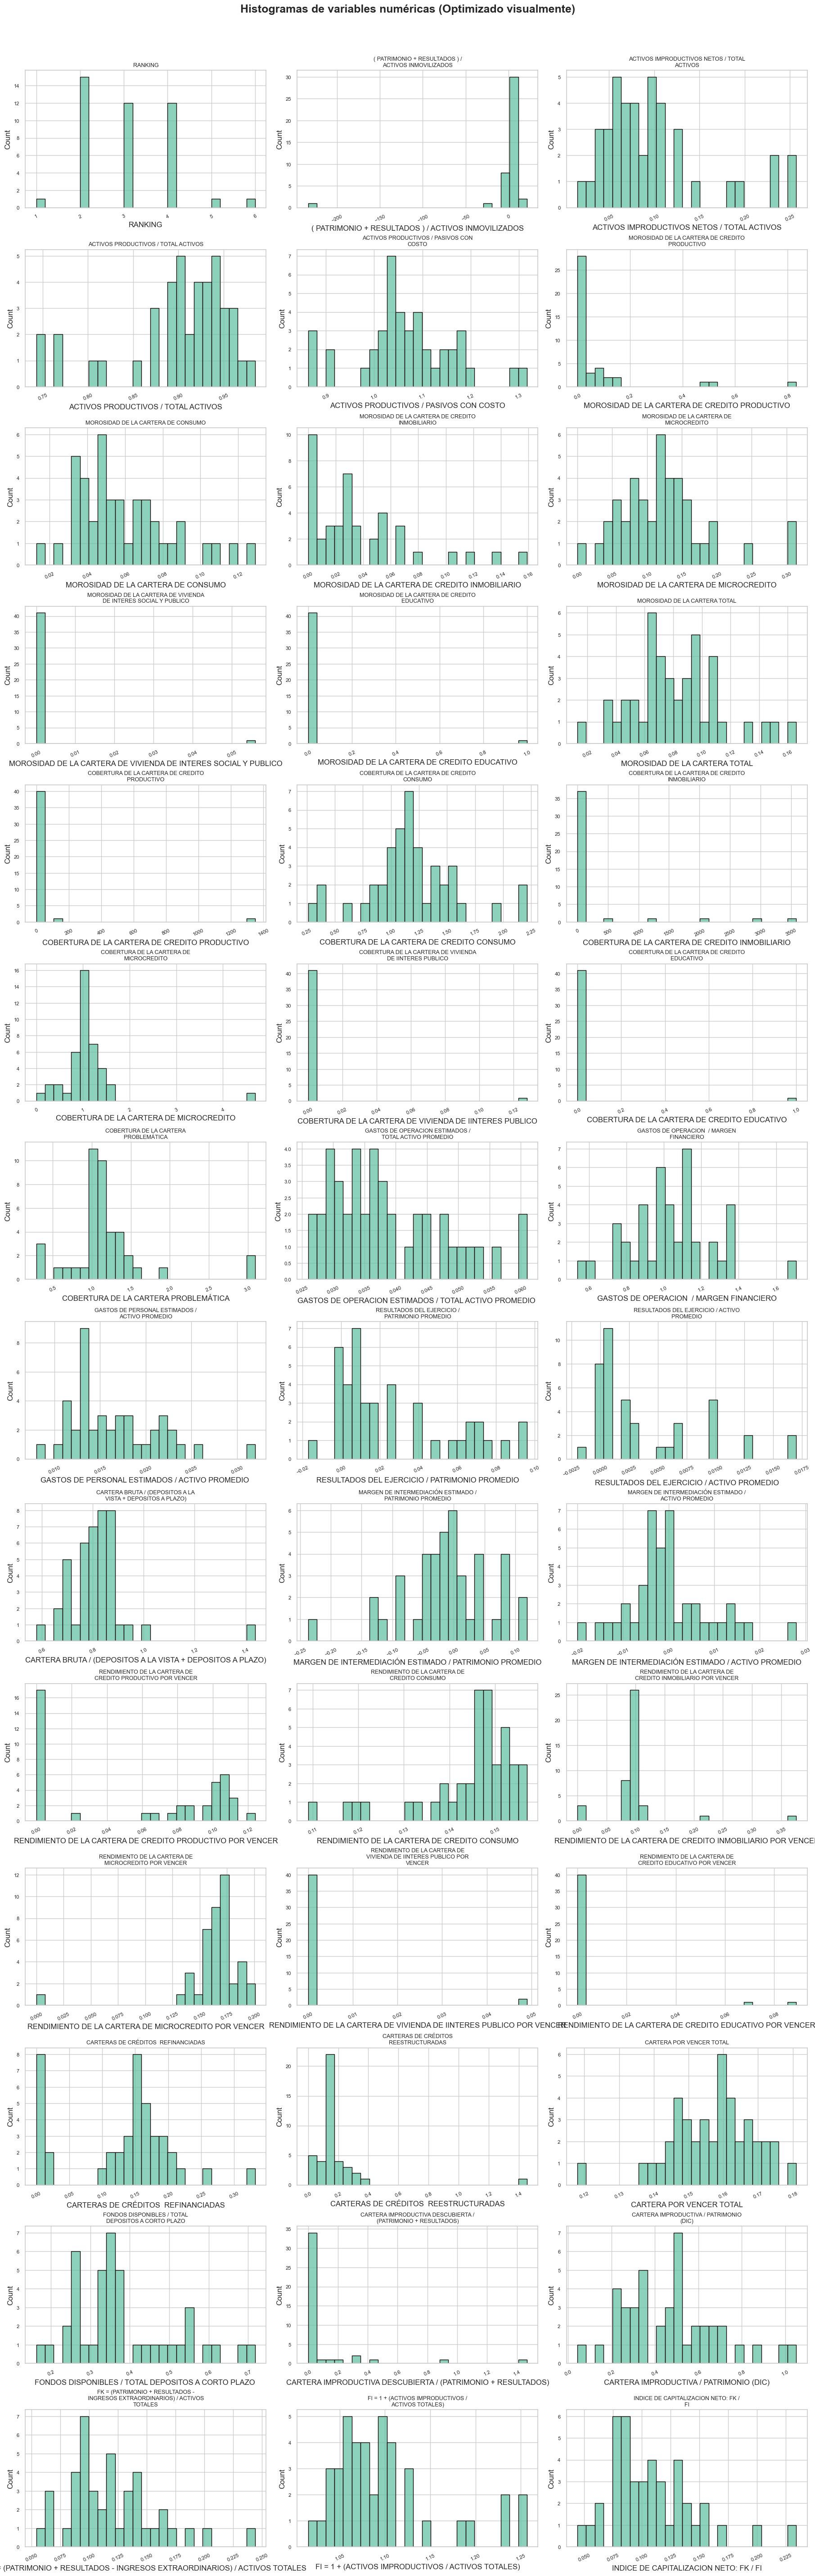

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import math

# Estilo general
sns.set(style="whitegrid", palette="Set2")

# DataFrame numérico ya limpio
df_plot = df_num[num_cols].copy()

# Configuración de grid
ncols = 3                                       # menos columnas → gráficos más grandes
nrows = math.ceil(len(df_plot.columns) / ncols)

fig, axes = plt.subplots(
    nrows,
    ncols,
    figsize=(18, 4 * nrows),
    constrained_layout=True
)
axes = axes.flatten()

for i, col in enumerate(df_plot.columns):
    sns.histplot(
        df_plot[col].dropna(),
        bins=25,
        ax=axes[i],
        edgecolor="black"
    )

    # Título multilínea bonito
    wrapped = "\n".join(textwrap.wrap(col, width=35))
    axes[i].set_title(wrapped, fontsize=9)

    axes[i].tick_params(axis="x", rotation=25, labelsize=8)
    axes[i].tick_params(axis="y", labelsize=8)

# Eliminar ejes vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle(
    "Histogramas de variables numéricas (Optimizado visualmente)",
    fontsize=18,
    weight="bold",
    y=1.02
)
plt.show()


### Heatmap y correlaciones

Realizamos heatmap que permite visualizar rápidamente qué pares de variables se mueven en conjunto (valores cercanos a ±1) y cuáles aportan información distinta (valores cercanos a 0). Identificar estas relaciones es útil para evitar redundancias: si dos variables están fuertemente correlacionadas, una puede explicar la misma tendencia que la otra,.

Por eso eliminamos las variables con correlaciones muy altas: reducimos multicolinealidad, simplificamos el espacio de características y mantenemos sólo los indicadores más independientes sin perder las señales financieras clave.

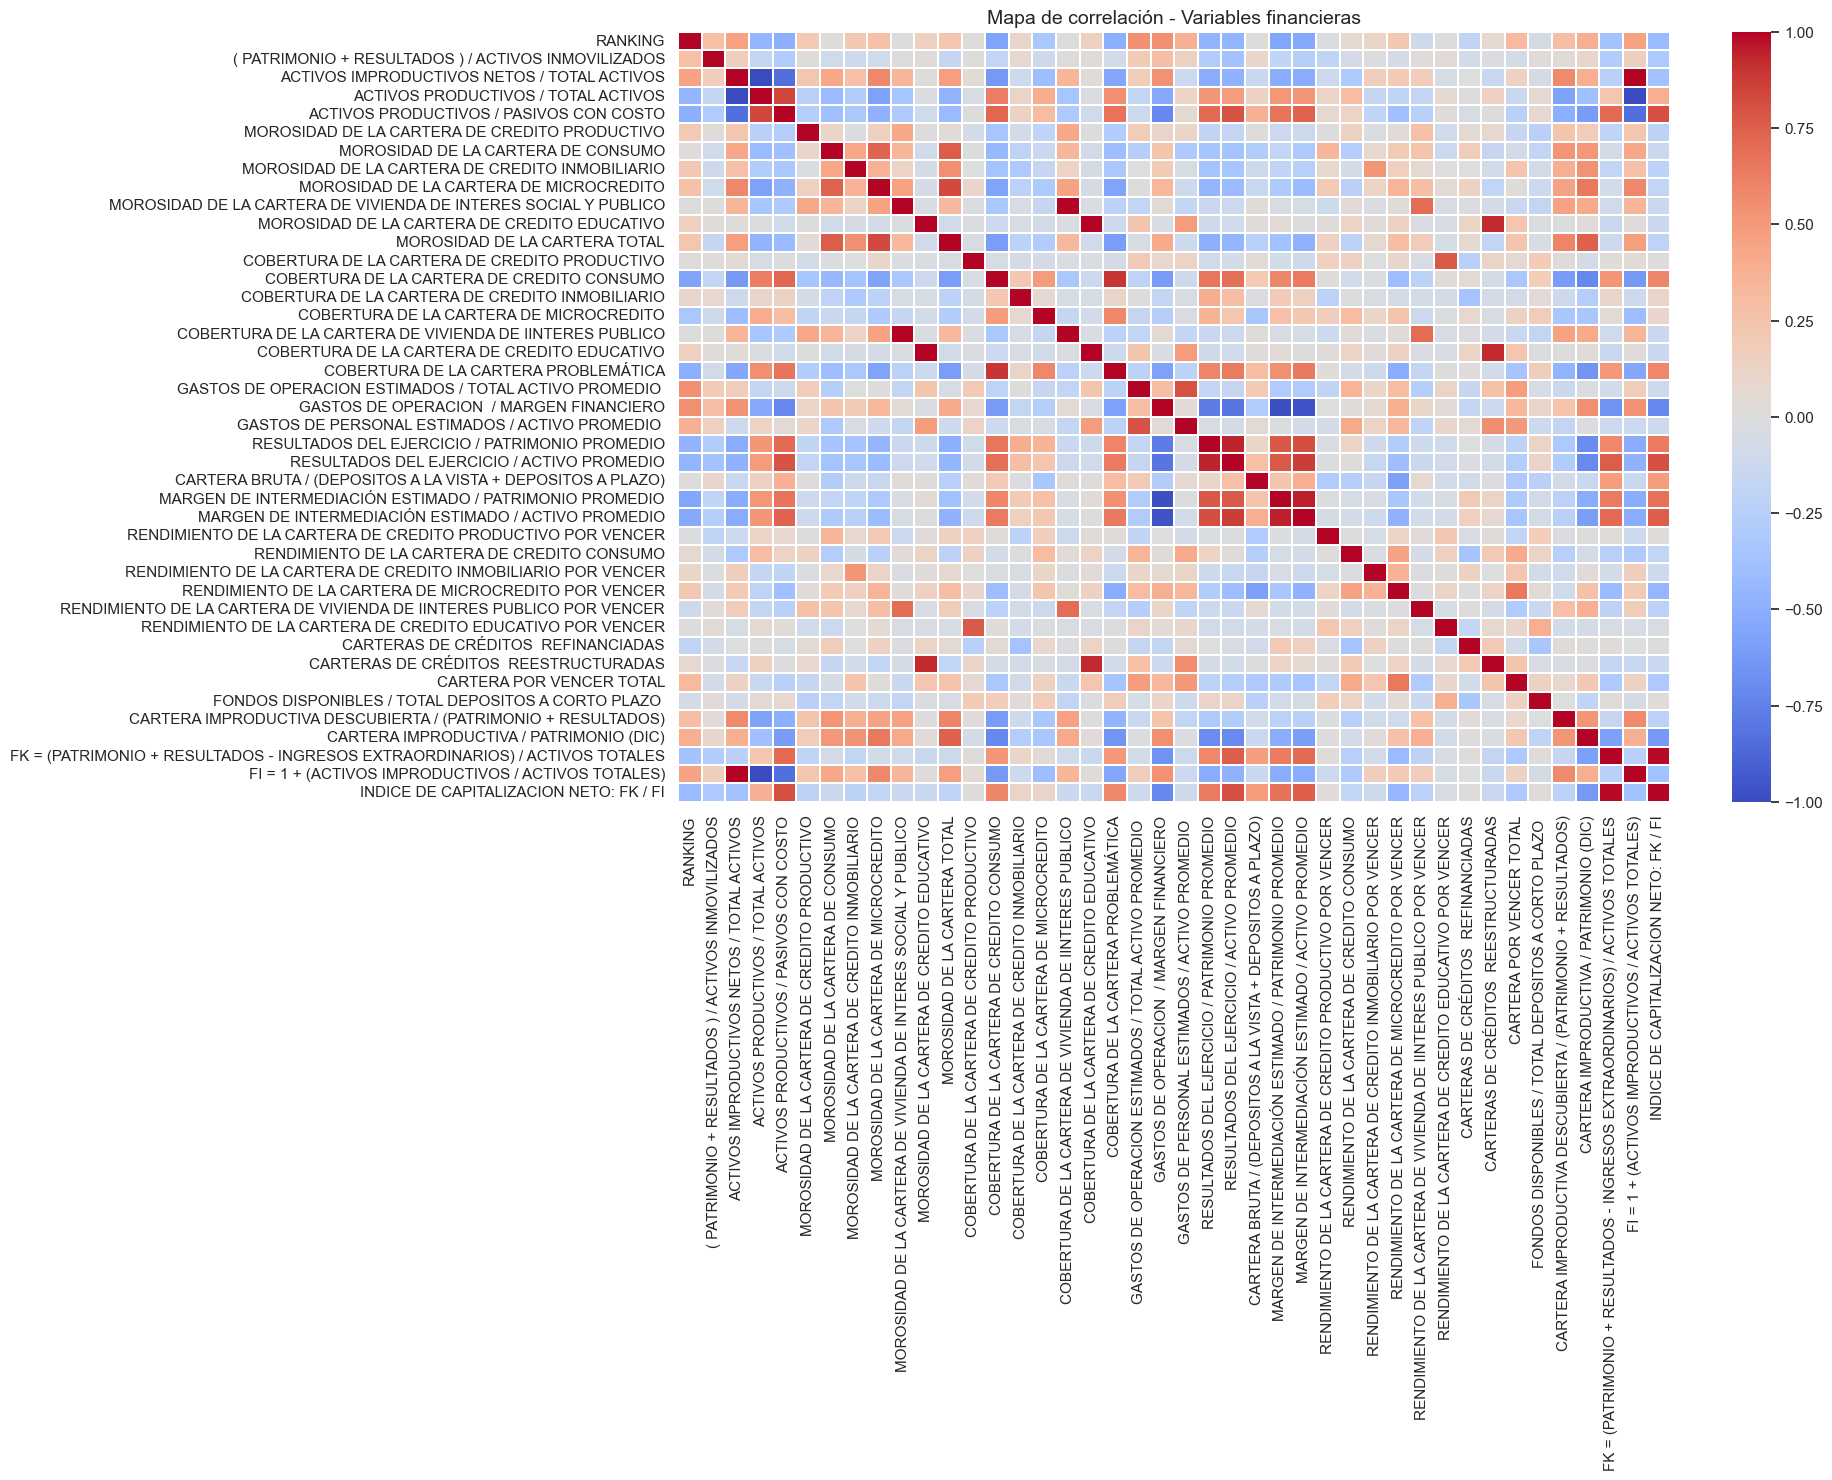


TOP correlaciones más fuertes:

MOROSIDAD DE LA CARTERA DE VIVIENDA DE INTERES SOCIAL Y PUBLICO              COBERTURA DE LA CARTERA DE VIVIENDA DE IINTERES PUBLICO                        1.000000
MOROSIDAD DE LA CARTERA DE CREDITO EDUCATIVO                                 COBERTURA DE LA CARTERA DE CREDITO EDUCATIVO                                   1.000000
ACTIVOS IMPRODUCTIVOS NETOS / TOTAL ACTIVOS                                  FI = 1 + (ACTIVOS IMPRODUCTIVOS / ACTIVOS TOTALES)                             1.000000
FK = (PATRIMONIO + RESULTADOS - INGRESOS EXTRAORDINARIOS) / ACTIVOS TOTALES  INDICE DE CAPITALIZACION NETO: FK / FI                                         0.987701
MARGEN DE INTERMEDIACIÓN ESTIMADO / PATRIMONIO PROMEDIO                      MARGEN DE INTERMEDIACIÓN ESTIMADO / ACTIVO PROMEDIO                            0.950554
RESULTADOS DEL EJERCICIO / PATRIMONIO PROMEDIO                               RESULTADOS DEL EJERCICIO / ACTIVO PROMEDIO                       

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_num[num_cols].corr()

plt.figure(figsize=(16,10))
sns.heatmap(corr, cmap="coolwarm", center=0, linewidths=0.3)
plt.title("Mapa de correlación - Variables financieras", fontsize=14)
plt.show()

# Top correlaciones absolutas
corr_pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        .stack()
        .sort_values(ascending=False)
)

print("\nTOP correlaciones más fuertes:\n")
print(corr_pairs.head(25))


### Eliminación de correlaciones

Se eliminan variables altamente correlacionadas para reducir redundancia y evitar problemas estadísticos y de modelado. Breve motivo y efectos:
No se eliminan variables con correlacion negativa

In [36]:
vars_drop_corr = [
    'MOROSIDAD DE LA CARTERA DE VIVIENDA DE INTERES SOCIAL Y PUBLICO',
    'MOROSIDAD DE LA CARTERA DE CREDITO EDUCATIVO',
    'ACTIVOS IMPRODUCTIVOS NETOS / TOTAL ACTIVOS',
    'FK = (PATRIMONIO + RESULTADOS - INGRESOS EXTRAORDINARIOS) / ACTIVOS TOTALES',
    'MARGEN DE INTERMEDIACIÓN ESTIMADO / PATRIMONIO PROMEDIO',
    'RESULTADOS DEL EJERCICIO / PATRIMONIO PROMEDIO',
    'MOROSIDAD DE LA CARTERA DE MICROCREDITO'
]

df_reducido = df_num.drop(columns=vars_drop_corr)
print("Shape después de reducir:", df_reducido.shape)


Shape después de reducir: (42, 39)


Eliminamos varaibles que nos nos sirve dentro del analisis

In [37]:
import numpy as np

# 1) Convertir todo a numerico
df_clean = df_reducido.apply(pd.to_numeric, errors="coerce")

# 2) Reemplazar infinitos por NaN
df_clean = df_clean.replace([np.inf, -np.inf], np.nan)

# 3) Eliminar columnas con demasiados NaN
df_clean = df_clean.dropna(axis=1, thresh=int(0.80*len(df_clean)))  # deja columnas con 80%+ datos válidos

# 4) Eliminar filas que aún tengan NaN
df_clean = df_clean.dropna()

#imprimir nombre de columnas eliminadas
cols_eliminadas = set(df_reducido.columns) - set(df_clean.columns)
print("Columnas eliminadas por demasiados NaN:", cols_eliminadas)
for col in cols_eliminadas:
    print("-", col)

print("Shape final para VIF:", df_clean.shape)
df_clean.head()


Columnas eliminadas por demasiados NaN: {'CALIFICACIÓN', 'CALIFICADORA', 'INSTITUCIÓN', 'SEGMENTO'}
- CALIFICACIÓN
- CALIFICADORA
- INSTITUCIÓN
- SEGMENTO
Shape final para VIF: (42, 35)


,RANKING,( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVILIZADOS,ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS,ACTIVOS PRODUCTIVOS / PASIVOS CON COSTO,MOROSIDAD DE LA CARTERA DE CREDITO PRODUCTIVO,MOROSIDAD DE LA CARTERA DE CONSUMO,MOROSIDAD DE LA CARTERA DE CREDITO INMOBILIARIO,MOROSIDAD DE LA CARTERA TOTAL,COBERTURA DE LA CARTERA DE CREDITO PRODUCTIVO,COBERTURA DE LA CARTERA DE CREDITO CONSUMO,...,RENDIMIENTO DE LA CARTERA DE VIVIENDA DE IINTERES PUBLICO POR VENCER,RENDIMIENTO DE LA CARTERA DE CREDITO EDUCATIVO POR VENCER,CARTERAS DE CRÉDITOS REFINANCIADAS,CARTERAS DE CRÉDITOS REESTRUCTURADAS,CARTERA POR VENCER TOTAL,FONDOS DISPONIBLES / TOTAL DEPOSITOS A CORTO PLAZO,CARTERA IMPRODUCTIVA DESCUBIERTA / (PATRIMONIO + RESULTADOS),CARTERA IMPRODUCTIVA / PATRIMONIO (DIC),FI = 1 + (ACTIVOS IMPRODUCTIVOS / ACTIVOS TOTALES),INDICE DE CAPITALIZACION NETO: FK / FI
0,1,-233.715,0.975,1.282,0.030,0.072,0.056,0.111,3.323,1.650,...,0.0,0.0,0.166,0.190,0.161,0.374,0.000,0.311,1.025,0.197
1,2,2.184,0.927,1.040,0.055,0.089,0.023,0.099,1.000,1.108,...,0.0,0.0,0.146,0.137,0.151,0.278,0.157,0.857,1.073,0.079
2,2,0.600,0.807,0.913,0.000,0.067,0.066,0.073,0.000,1.150,...,0.0,0.0,0.154,0.170,0.147,0.359,0.000,0.450,1.193,0.079
3,2,1.648,0.905,1.046,0.000,0.041,0.000,0.075,0.000,1.365,...,0.0,0.0,0.130,0.133,0.155,0.349,0.000,0.482,1.095,0.092
4,2,11.282,0.958,1.317,0.000,0.013,0.000,0.013,0.000,2.206,...,0.0,0.0,0.116,0.112,0.118,0.345,0.000,0.043,1.042,0.234


Buscamos variables que tenga un solo un dato y las eliminamos

Ademas de exploramos variables que tenga mucha varianza, no eliminaremos estas variables ya que en datos finacieros muy posiblemente nos puedan aportar algo de informacion

In [38]:

# 1. Porcentaje de ceros por variable 
percent_zeros = (df_clean == 0).mean() * 100

# 2. Varianza por variable 
variances = df_clean.var()

# 3. Unir todo en un mismo DataFrame
constant_check = pd.DataFrame({
    "percent_zeros": percent_zeros,
    "variance": variances
}).sort_values("percent_zeros", ascending=False)

# Mostrar el top
constant_check


,percent_zeros,variance
COBERTURA DE LA CARTERA DE CREDITO EDUCATIVO,97.619048,0.023810
COBERTURA DE LA CARTERA DE VIVIENDA DE IINTERES PUBLICO,97.619048,0.000390
RENDIMIENTO DE LA CARTERA DE CREDITO EDUCATIVO POR VENCER,95.238095,0.000301
RENDIMIENTO DE LA CARTERA DE VIVIENDA DE IINTERES PUBLICO POR VENCER,95.238095,0.000112
CARTERA IMPRODUCTIVA DESCUBIERTA / (PATRIMONIO + RESULTADOS),66.666667,0.074602
COBERTURA DE LA CARTERA DE CREDITO PRODUCTIVO,45.238095,43527.428158
MOROSIDAD DE LA CARTERA DE CREDITO PRODUCTIVO,45.238095,0.026708
RENDIMIENTO DE LA CARTERA DE CREDITO PRODUCTIVO POR VENCER,40.476190,0.002484
MOROSIDAD DE LA CARTERA DE CREDITO INMOBILIARIO,23.809524,0.001440
CARTERAS DE CRÉDITOS REFINANCIADAS,19.047619,0.006571


Dado que las variables de COBERTURA DE LA CARTERA DE CREDITO EDUCATIVO y COBERTURA DE LA CARTERA DE VIVIENDA DE IINTERES PUBLICO. 

Tiene unicamente un dato en la columna la eliminamos, practicamente no nos revelan casi nada de informaicion. 

In [39]:
# Eliminar columnas específicas si existen (evita usar drop por index)
cols_to_drop = [
    'COBERTURA DE LA CARTERA DE CREDITO EDUCATIVO',
    'COBERTURA DE LA CARTERA DE VIVIENDA DE IINTERES PUBLICO'
]

removed = []
for c in cols_to_drop:
    if c in df_clean.columns:
        df_clean.drop(columns=c, inplace=True)
        removed.append(c)

print(f"Columnas eliminadas: {removed}" if removed else "No se eliminaron columnas (no estaban presentes)")
print("Shape final después de eliminar columnas:", df_clean.shape)
df_clean.head()

Columnas eliminadas: ['COBERTURA DE LA CARTERA DE CREDITO EDUCATIVO', 'COBERTURA DE LA CARTERA DE VIVIENDA DE IINTERES PUBLICO']
Shape final después de eliminar columnas: (42, 33)


,RANKING,( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVILIZADOS,ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS,ACTIVOS PRODUCTIVOS / PASIVOS CON COSTO,MOROSIDAD DE LA CARTERA DE CREDITO PRODUCTIVO,MOROSIDAD DE LA CARTERA DE CONSUMO,MOROSIDAD DE LA CARTERA DE CREDITO INMOBILIARIO,MOROSIDAD DE LA CARTERA TOTAL,COBERTURA DE LA CARTERA DE CREDITO PRODUCTIVO,COBERTURA DE LA CARTERA DE CREDITO CONSUMO,...,RENDIMIENTO DE LA CARTERA DE VIVIENDA DE IINTERES PUBLICO POR VENCER,RENDIMIENTO DE LA CARTERA DE CREDITO EDUCATIVO POR VENCER,CARTERAS DE CRÉDITOS REFINANCIADAS,CARTERAS DE CRÉDITOS REESTRUCTURADAS,CARTERA POR VENCER TOTAL,FONDOS DISPONIBLES / TOTAL DEPOSITOS A CORTO PLAZO,CARTERA IMPRODUCTIVA DESCUBIERTA / (PATRIMONIO + RESULTADOS),CARTERA IMPRODUCTIVA / PATRIMONIO (DIC),FI = 1 + (ACTIVOS IMPRODUCTIVOS / ACTIVOS TOTALES),INDICE DE CAPITALIZACION NETO: FK / FI
0,1,-233.715,0.975,1.282,0.030,0.072,0.056,0.111,3.323,1.650,...,0.0,0.0,0.166,0.190,0.161,0.374,0.000,0.311,1.025,0.197
1,2,2.184,0.927,1.040,0.055,0.089,0.023,0.099,1.000,1.108,...,0.0,0.0,0.146,0.137,0.151,0.278,0.157,0.857,1.073,0.079
2,2,0.600,0.807,0.913,0.000,0.067,0.066,0.073,0.000,1.150,...,0.0,0.0,0.154,0.170,0.147,0.359,0.000,0.450,1.193,0.079
3,2,1.648,0.905,1.046,0.000,0.041,0.000,0.075,0.000,1.365,...,0.0,0.0,0.130,0.133,0.155,0.349,0.000,0.482,1.095,0.092
4,2,11.282,0.958,1.317,0.000,0.013,0.000,0.013,0.000,2.206,...,0.0,0.0,0.116,0.112,0.118,0.345,0.000,0.043,1.042,0.234


### PCA (reducción dimensional y visualización)

--¿Qué es la varianza explicada en PCA?

El PCA (Análisis de Componentes Principales) transforma tus variables originales en nuevas variables llamadas componentes principales (PCs).
Cada PC captura una parte de la variabilidad total de los datos.

PCA ayuda en el análisis exploratorio: tpermite ver patrones, tendencias, estructuras latentes, valores atípicos, etc., en un espacio más compacto, lo que puede revelar relaciones difíciles de ver cuando tienes decenas de variables.

(https://www.ibm.com/es-es/think/topics/principal-component-analysis)

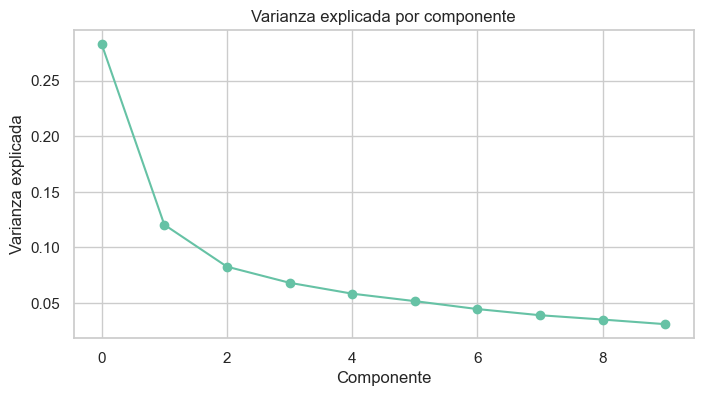

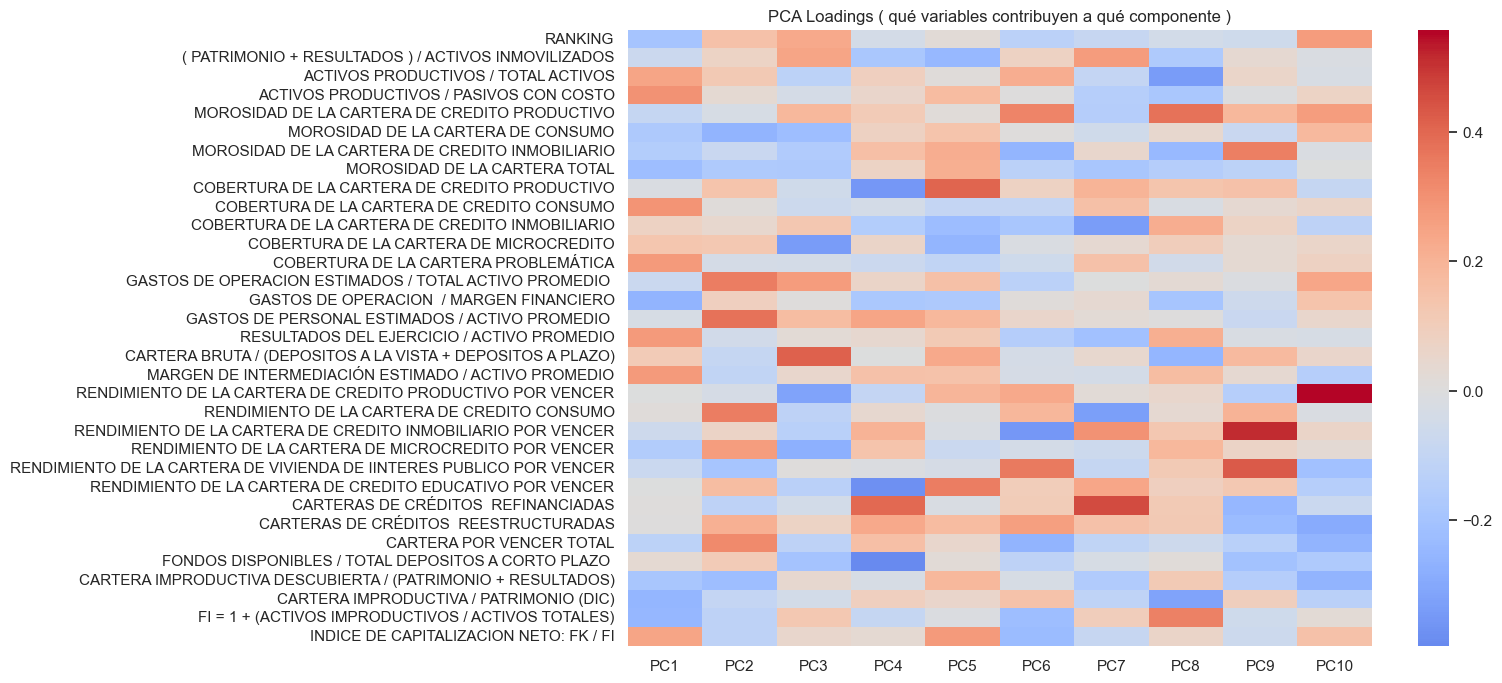

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
RANKING,-0.197840,0.151234,0.231048,-0.039574,0.018724,-0.129390,-0.088974,-0.047074,-0.057944,0.269056
( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVILIZADOS,-0.071089,0.070978,0.244857,-0.183549,-0.244618,0.077581,0.274724,-0.164203,0.034163,-0.012316
ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS,0.246803,0.120729,-0.123189,0.092200,0.008930,0.221043,-0.098747,-0.339397,0.058539,-0.024625
ACTIVOS PRODUCTIVOS / PASIVOS CON COSTO,0.293811,0.031102,-0.034025,0.054323,0.171669,0.000297,-0.146009,-0.182397,-0.004788,0.072512
MOROSIDAD DE LA CARTERA DE CREDITO PRODUCTIVO,-0.091137,-0.029132,0.182482,0.111088,0.017299,0.331819,-0.151026,0.378402,0.183719,0.266829
MOROSIDAD DE LA CARTERA DE CONSUMO,-0.169327,-0.261083,-0.224556,0.081299,0.139281,0.004783,-0.053052,0.046923,-0.079088,0.181634
MOROSIDAD DE LA CARTERA DE CREDITO INMOBILIARIO,-0.155571,-0.081699,-0.163528,0.158965,0.222867,-0.257212,0.048280,-0.240218,0.343982,-0.016760
MOROSIDAD DE LA CARTERA TOTAL,-0.221534,-0.167117,-0.172007,0.074196,0.214528,-0.129552,-0.189030,-0.152401,-0.123071,-0.002029
COBERTURA DE LA CARTERA DE CREDITO PRODUCTIVO,-0.016217,0.144644,-0.054544,-0.349711,0.407964,0.077768,0.197266,0.134278,0.149696,-0.094782
COBERTURA DE LA CARTERA DE CREDITO CONSUMO,0.290328,0.007706,-0.070023,-0.043726,-0.097241,-0.098294,0.153990,-0.020738,0.036872,0.062934


In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Estandarización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean)

# PCA
pca = PCA(n_components=min(10, df_clean.shape[1]))
X_pca = pca.fit_transform(X_scaled)

# Varianza explicada
plt.figure(figsize=(8,4))
plt.plot(pca.explained_variance_ratio_, marker='o')
plt.title("Varianza explicada por componente")
plt.xlabel("Componente")
plt.ylabel("Varianza explicada")
plt.grid(True)
plt.show()

# Heatmap de cargas del PCA
loadings = pd.DataFrame(
    pca.components_.T,
    index=df_clean.columns,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

plt.figure(figsize=(12, 8))
sns.heatmap(loadings, cmap="coolwarm", center=0)
plt.title("PCA Loadings ( qué variables contribuyen a qué componente )")
plt.show()

loadings


Pantalla 1 — Varianza explicada 
El gráfico muestra algo así como:

PC1 ≈ 26%
PC2 ≈ 12–13%
PC3, PC4, PC5 ≈ 7–8%
El resto ≈ 5% o menos cada uno

EL dataset NO tiene una estructura dominante fuerte. No hay un “super-factor” financiero que explique todo. Ademas de que los datos están distribuidos en muchas dimensiones, típico en ratios bancarios.

PC1 y PC2 capturan juntas ~38–40%, que es aceptable pero no lo suficiente para comprimir datos sin pérdida.

Conclusión: Se necesitarías 6–8 componentes para representar ~70% de la varianza total.

Pantalla 2 — Heat map

PC1:

- Variables relacionadas con activos productivos, eficiencia y morosidades tienen colores fuertes.
- Esto sugiere que PC1 mide tamaño, eficiencia y rendimiento del portafolio.

PC2:

- Más relacionado con coberturas y riesgos de cartera.
- Representa comportamiento de provisiones vs carteras.

✔ PC3–PC6:

- RENDIMIENTOS por tipo de cartera
- Coberturas específicas
- Activos improductivos / FI



🔥 Conclusión del heatmap:

No hay una sola dimensión que explique todo.Las variables representan muchos “ejes financieros” diferentes. 

PCA supone relaciones lineales entre variables, los datos no necesariamente tiene relaciones lineales. Ademas queremos preservar la relaciones mas veraces para las observaciones por lo que no usaremos PCA en clusters sino los datos en si

### Importancia de variables con un Random Forest 

Se Hace un Random Forest para ver la impostancia de variables, no se estratifican las variables porque solo se quieren ver la importancia

La importancia de variables en Random Forest se calcula usando:

- cuánta reducción de impureza genera cada variable en los árboles

- o cuánta reducción de error produce cuando se usa en decisiones

Porque un RandonForest
- Maneja relaciones no lineales
- No sufre por multicolinealidad
- Estable y robusto
- Es interpretativo, util para el modelo finaciero
- Es popular en para la explicacion de prediciones 

(https://arxiv.org/html/2509.26299v1)

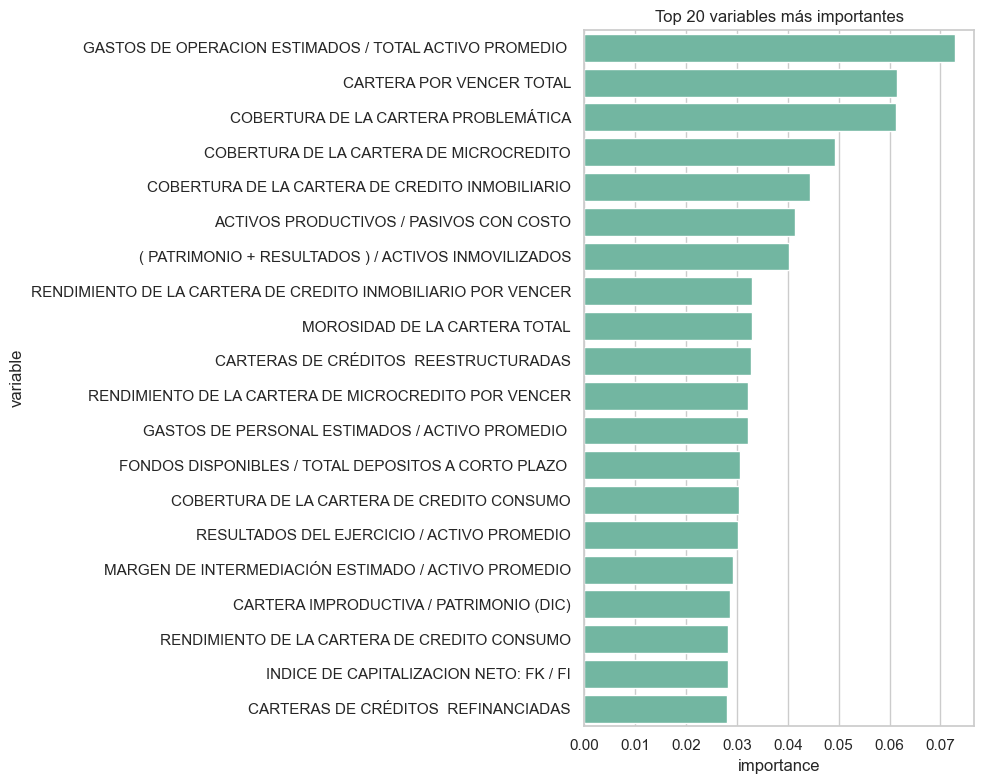

,variable,importance
12,GASTOS DE OPERACION ESTIMADOS / TOTAL ACTIVO P...,0.072939
26,CARTERA POR VENCER TOTAL,0.061544
11,COBERTURA DE LA CARTERA PROBLEMÁTICA,0.061169
10,COBERTURA DE LA CARTERA DE MICROCREDITO,0.049188
9,COBERTURA DE LA CARTERA DE CREDITO INMOBILIARIO,0.044274
2,ACTIVOS PRODUCTIVOS / PASIVOS CON COSTO,0.041481
0,( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVILI...,0.040222
20,RENDIMIENTO DE LA CARTERA DE CREDITO INMOBILIA...,0.033015
6,MOROSIDAD DE LA CARTERA TOTAL,0.032930
25,CARTERAS DE CRÉDITOS REESTRUCTURADAS,0.032803


In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Separar features y target ---
X = df_clean.drop(columns=["RANKING"])
y = df_clean["RANKING"]

# --- 2. Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- 3. Random Forest como baseline ---
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

# --- 4. Importancia de variables ---
importances = pd.DataFrame({
    "variable": X.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

# Gráfico
plt.figure(figsize=(10, 8))
sns.barplot(data=importances.head(20), x="importance", y="variable")
plt.title("Top 20 variables más importantes")
plt.tight_layout()
plt.show()

importances.head(20)



Analisis del top de variables

1.- GASTOS DE OPERACIÓN ESTIMADOS / TOTAL ACTIVO PROMEDIO: 
- Mide la eficiencia operativa.
- Cooperativas que gastan mucho para generar crédito → menor eficiencia → ratings más bajos.

2.- CARTERA POR VENCER TOTAL
- tamaño
- capacidad colocacion
- estructura de cartera viva

3.- COBERTURA DE LA CARTERA PROBLEMÁTICA
- Una cooperativa que provisiona bien → menos riesgo → rating mejor
- Baja cobertura → riesgo de pérdida → rating peor

siguientes variables COBERTURA MULTIPLES:
- creditos productivo
- micorcreditos
- inmobiliario
- consumo
Porque los ratings evalúan la calidad de cartera por cada segmento.
El modelo ve estas coberturas como señales fuertes de riesgo.

### TSNE

Es una técnica no supervisada de reducción de dimensionalidad. Comprime tus 30–40 variables financieras en 2 o 3 dimensiones.

- Su objetivo: conservar relaciones locales (quién es similar a quién).
- La usamos para ver las agrupasciones por el ranking de mejor manera

In [42]:
#Escalamos los datos

from sklearn.preprocessing import StandardScaler

# X = todas las variables numéricas del clustering (sin el RANKING si será la etiqueta)
X = df_clean.drop(columns=["RANKING"])  

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [43]:
#t-SNE 2D para visualización

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

tsne = TSNE(
    n_components=2,        # para visualizar en 2D
    perplexity=15,         # cuántos vecinos cercanos considera
    learning_rate=200,     # separa de mejor forma los datos
    max_iter= 1000,
    init='pca',           # iniciacion mas estable
    random_state=42
)

X_tsne = tsne.fit_transform(X_scaled)

# Convertir a DataFrame
tsne_df = df_clean.copy()
tsne_df["TSNE1"] = X_tsne[:, 0]
tsne_df["TSNE2"] = X_tsne[:, 1]


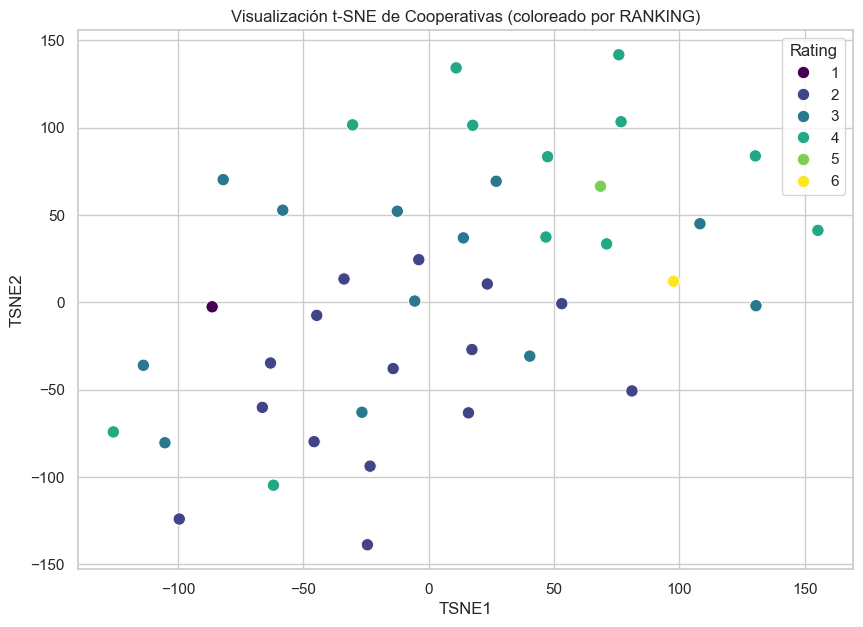

In [44]:
#visualizar puVisualizar puntos coloreados por Rating

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=tsne_df,
    x="TSNE1",
    y="TSNE2",
    hue="RANKING",        # Que los colores representen el rating real
    palette="viridis",
    s=80
)
plt.title("Visualización t-SNE de Cooperativas (coloreado por RANKING)")
plt.legend(title="Rating")
plt.show()


Analisis

* Hay una nube de cooperativas con rating alto (1‑3) agrupadas en la parte izquierda‑abajo, con pocos puntos dispersos, lo que sugiere perfiles financieros similares.
* En la zona central y superior aparecen ratings medios (4‑5) más dispersos, mostrando más variabilidad interna.
* El único rating 6 queda aislado en el cuadrante superior derecho, indicando que su perfil es bastante distinto del resto.
* No se forman grupos muy compactos, pero sí un gradiente: los rankings mejores tienden a agruparse y los peores se separan, lo que sugiere que alguno de los clusters está capturando esa división.
* También se aprecia que algunos ratings cercanos (ej. 3 y 4) se mezclan, lo que refleja que la frontera entre ellos no es nítida.

# Clustering

Para clustering usamos tres metodos comparativos para ver que tan biense separa la data:

-K-means (Baselina - obligatorio)
* Asume clusters esfericos
* Usa distancia Euclidiana
* Rapido y funciona bien con datos escalados

El algoritmo K-means funciona asignando datos a \(K\) grupos (clústeres) de forma iterativa. 

-Spectral Clustering (https://www.geeksforgeeks.org/machine-learning/ml-spectral-clustering/)
* Tiene ratios no lineales
* Tiene correlaciones fuertes
* Tiene curvaturas en el espacio
* Usa vectores propios, Se basaen la idea de una representacion mediante un borde

El algoritmo implica construir un grafo, determinar su matriz laplaciana y, a partir de esta matriz, hallar k vectores propios para dividir el grafo en k partes.

Gaussian Mixture Models (https://www.geeksforgeeks.org/machine-learning/gaussian-mixture-model/)
* Permite clusters elípticos (no esféricos como K-Means)
* Permite solapamiento (lo cual es real: cooperativas pueden ser parecidas)
* Es probabilístico 
* Permite interpretar la densidad, útil en datos financieros

El GMM se entrena mediante el algoritmo EM, un enfoque iterativo para determinar las estimaciones más probables de los parámetros de la distribución gaussiana mixta. El método EM primero realiza estimaciones aproximadas de los parámetros y luego las mejora repetidamente hasta alcanzar la convergencia.

Opcion alternativa DBSCAN (https://www.datacamp.com/es/tutorial/dbscan-clustering-algorithm)
DBSCAN funciona identificando puntos de datos de alta densidad en clústeres y marcando los puntos de baja densidad como ruido 

In [45]:
#Standarizacion de los datos
from sklearn.preprocessing import StandardScaler

X = df_clean.drop(columns=["RANKING"])  # quitar etiquetas si están
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
plt.show()


Metodo del codo

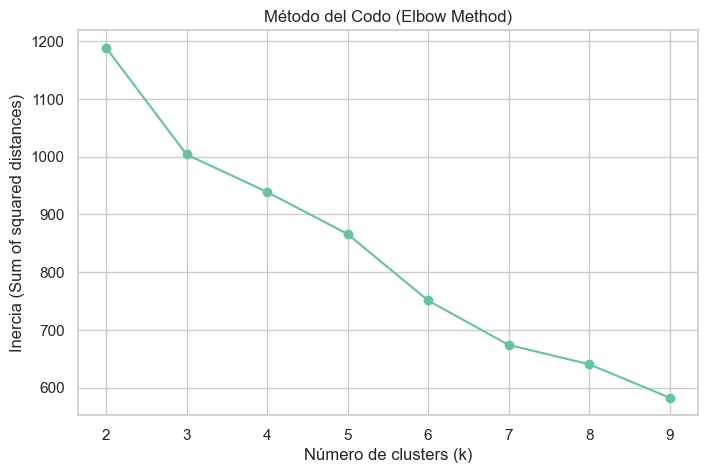

In [46]:
# Metodo del codo 

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K_range = range(2, 10)  # probar k de 2 a 9 (evita k=1 que rompe silhouette)

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    inertias.append(model.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.title("Método del Codo (Elbow Method)")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia (Sum of squared distances)")
plt.grid(True)
plt.show()



silhouette score

El puntaje Silhouette evalúa qué tan bien encaja cada punto de datos dentro de su grupo asignado y qué tan claramente separado está de otros grupos. Para cada punto de datos se calculan dos cantidades principales

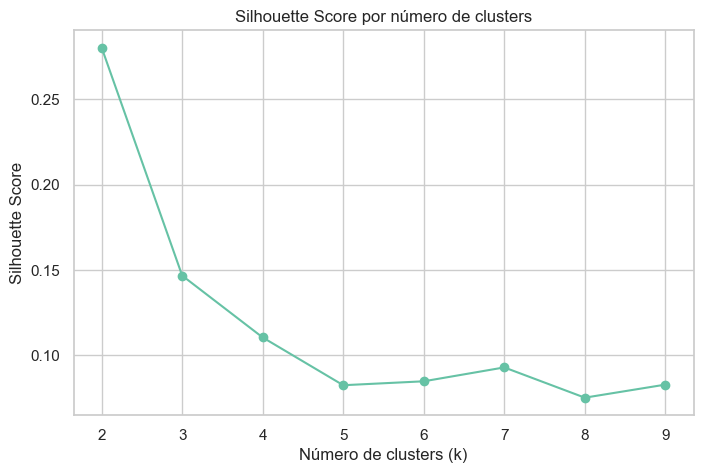

k=2: silhouette=0.2803
k=3: silhouette=0.1466
k=4: silhouette=0.1103
k=5: silhouette=0.0823
k=6: silhouette=0.0846
k=7: silhouette=0.0928
k=8: silhouette=0.0750
k=9: silhouette=0.0827


In [47]:
# metodo silhouette score

from sklearn.metrics import silhouette_score

sil_scores = []

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

plt.figure(figsize=(8, 5))
plt.plot(K_range, sil_scores, marker='o')
plt.title("Silhouette Score por número de clusters")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

for k, sil in zip(K_range, sil_scores):
    print(f"k={k}: silhouette={sil:.4f}")



Método del codo :

- La inercia baja mas o menos fuerte entre k=1 y k=2, y luego el descenso se hace más suave.

Silhouette:

- k=2 → 0.28 (muy por encima del resto).
- A partir de k=3 todas las siluetas caen a ~0.15 o menos, lo que indica:

Para este dataset y estos features escalados, el modelo K-Means con 2 clusters ofrece la mejor separación global según la silhouette y es coherente con el codo. Como  necesitamos más granularidad  se podria analizar también k=3, pero estadísticamente k=2 es el más sólido.



In [48]:
k_opt = 3  # cambiado por el mejor k 


In [49]:
#kmeans

kmeans = KMeans(n_clusters=k_opt, random_state=42)
df_clean["cluster_kmeans"] = kmeans.fit_predict(X_scaled)


In [50]:
#Spectral Clustering

from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(
    n_clusters=k_opt,
    affinity='nearest_neighbors',
    n_neighbors=10,
    random_state=42
)

df_clean["cluster_spectral"] = spectral.fit_predict(X_scaled)


In [51]:
#GaussianMisture

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(
    n_components=k_opt,
    covariance_type='full',
    random_state=42
)

df_clean["cluster_gmm"] = gmm.fit_predict(X_scaled)


In [52]:
#DBSCAN (solo para ver si hay alguna diferencia)
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(
    eps=3.0,          # <--- Ajusta: prueba 0.5, 1.0, 1.5, 2.0
    min_samples=2    # <--- Ajusta: prueba 3, 5, 8
)

db_labels = dbscan.fit_predict(X_scaled)
df_clean["cluster_dbscan"] = db_labels

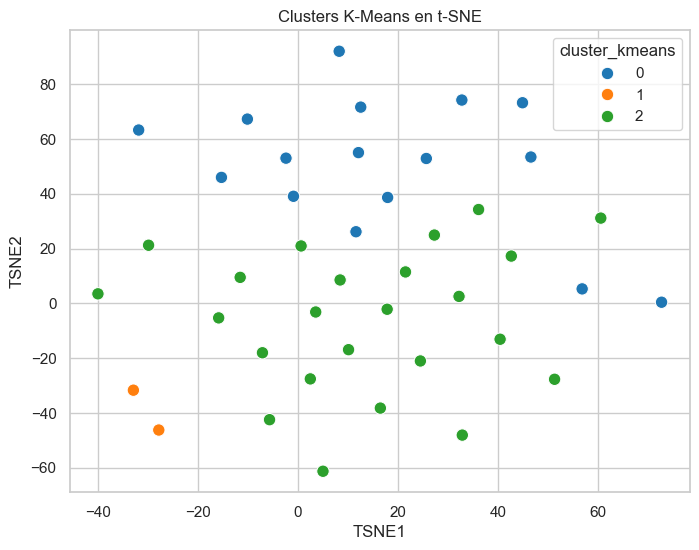

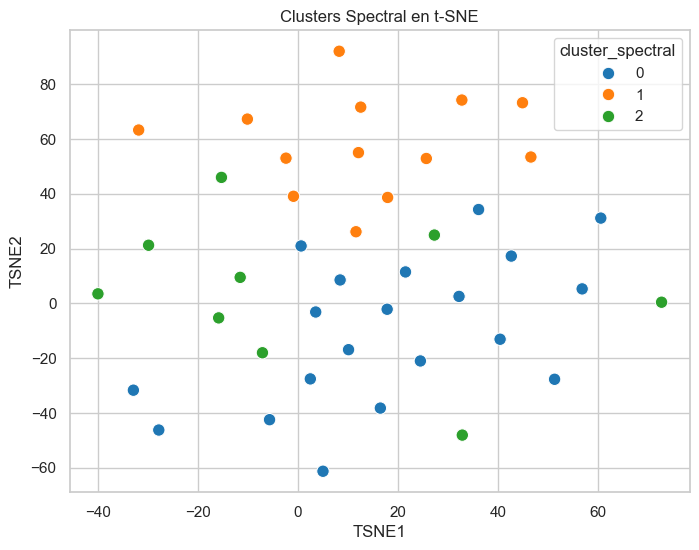

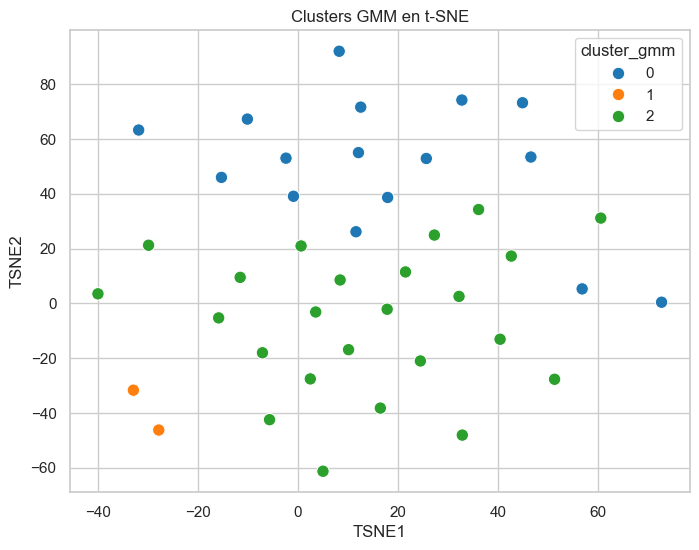

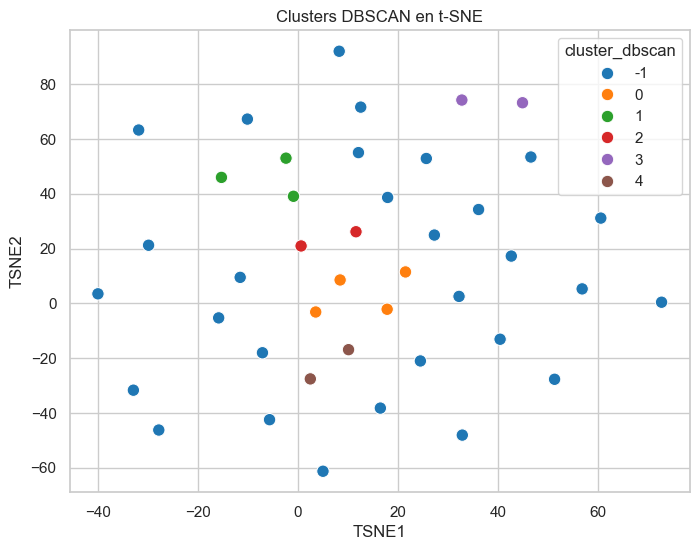

In [53]:
#Usamos TSNE para ver los clusters de mejor forma

from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

tsne = TSNE(
    n_components=2,
    perplexity=20,
    learning_rate=200,
    max_iter=1500,
    init='pca',
    random_state=42
)

X_tsne = tsne.fit_transform(X_scaled)

df_clean["TSNE1"] = X_tsne[:, 0]
df_clean["TSNE2"] = X_tsne[:, 1]

# KMEANS
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_clean, x="TSNE1", y="TSNE2", hue="cluster_kmeans", palette="tab10", s=80)
plt.title("Clusters K-Means en t-SNE")
plt.show()

# SPECTRAL
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_clean, x="TSNE1", y="TSNE2", hue="cluster_spectral", palette="tab10", s=80)
plt.title("Clusters Spectral en t-SNE")
plt.show()

# GMM
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_clean, x="TSNE1", y="TSNE2", hue="cluster_gmm", palette="tab10", s=80)
plt.title("Clusters GMM en t-SNE")
plt.show()

#DBSCAN (solo para ver mas diferenciacion)
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_clean, x="TSNE1", y="TSNE2", hue="cluster_dbscan", palette="tab10", s=80)
plt.title("Clusters DBSCAN en t-SNE")
plt.show()

### Tabla resumen para K-Means

In [54]:
# Resumen por cluster K-MEANS
summary_kmeans = df_clean.groupby("cluster_kmeans").mean(numeric_only=True)
summary_kmeans


,RANKING,( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVILIZADOS,ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS,ACTIVOS PRODUCTIVOS / PASIVOS CON COSTO,MOROSIDAD DE LA CARTERA DE CREDITO PRODUCTIVO,MOROSIDAD DE LA CARTERA DE CONSUMO,MOROSIDAD DE LA CARTERA DE CREDITO INMOBILIARIO,MOROSIDAD DE LA CARTERA TOTAL,COBERTURA DE LA CARTERA DE CREDITO PRODUCTIVO,COBERTURA DE LA CARTERA DE CREDITO CONSUMO,...,FONDOS DISPONIBLES / TOTAL DEPOSITOS A CORTO PLAZO,CARTERA IMPRODUCTIVA DESCUBIERTA / (PATRIMONIO + RESULTADOS),CARTERA IMPRODUCTIVA / PATRIMONIO (DIC),FI = 1 + (ACTIVOS IMPRODUCTIVOS / ACTIVOS TOTALES),INDICE DE CAPITALIZACION NETO: FK / FI,cluster_spectral,cluster_gmm,cluster_dbscan,TSNE1,TSNE2
cluster_kmeans,,,,,,,,,,,,,,,,,,,,,
0,2.500000,-11.100875,0.939812,1.155563,0.023938,0.048438,0.020938,0.063937,85.030812,1.518938,...,0.427875,0.000000,0.279687,1.060188,0.140313,1.062500,0.0,0.062500,17.592503,50.742561
1,3.500000,0.523000,0.756500,0.875000,0.256500,0.122500,0.092000,0.156000,71.488000,0.303500,...,0.346500,1.178500,0.912500,1.243500,0.084500,0.000000,1.0,-1.000000,-30.343435,-38.962673
2,3.291667,2.587208,0.887875,1.022000,0.084292,0.061750,0.042833,0.087125,1.035292,1.026375,...,0.352625,0.071125,0.565750,1.112125,0.089958,0.583333,2.0,-0.291667,13.504579,-5.813537


In [55]:
summary_kmeans_with_count = df_clean.groupby("cluster_kmeans").agg(["mean", "count"])
summary_kmeans_with_count


RANKING        \
                    mean count   
cluster_kmeans                   
0               2.500000    16   
1               3.500000     2   
2               3.291667    24   

               ( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVILIZADOS        \
                                                              mean count   
cluster_kmeans                                                             
0                                                      -11.100875     16   
1                                                        0.523000      2   
2                                                        2.587208     24   

               ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS        \
                                              mean count   
cluster_kmeans                                             
0                                         0.939812    16   
1                                         0.756500     2   
2                                         0.887875    24   

               ACTIVOS PRODUCTIVOS / PASIVOS CON COSTO        \
                                                  mean count   
cluster_kmeans                                                 
0                                             1.155563    16   
1                                             0.875000     2   
2                                             1.022000    24   

               MOROSIDAD DE LA CARTERA DE CREDITO PRODUCTIVO        ...  \
                                                        mean count  ...   
cluster_kmeans                                                      ...   
0                                                   0.023938    16  ...   
1                                                   0.256500     2  ...   
2                                                   0.084292    24  ...   

               cluster_spectral       cluster_gmm       cluster_dbscan        \
                           mean count        mean count           mean count   
cluster_kmeans                                                                 
0                      1.062500    16         0.0    16       0.062500    16   
1                      0.000000     2         1.0     2      -1.000000     2   
2                      0.583333    24         2.0    24      -0.291667    24   

                    TSNE1            TSNE2        
                     mean count       mean count  
cluster_kmeans                                    
0               17.592503    16  50.742561    16  
1              -30.343435     2 -38.962673     2  
2               13.504579    24  -5.813537    24  

[3 rows x 76 columns]

### Tabla resumen para Spectral Clustering

In [56]:
# Resumen por cluster SPECTRAL
summary_spectral = df_clean.groupby("cluster_spectral").mean(numeric_only=True)
summary_spectral


,RANKING,( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVILIZADOS,ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS,ACTIVOS PRODUCTIVOS / PASIVOS CON COSTO,MOROSIDAD DE LA CARTERA DE CREDITO PRODUCTIVO,MOROSIDAD DE LA CARTERA DE CONSUMO,MOROSIDAD DE LA CARTERA DE CREDITO INMOBILIARIO,MOROSIDAD DE LA CARTERA TOTAL,COBERTURA DE LA CARTERA DE CREDITO PRODUCTIVO,COBERTURA DE LA CARTERA DE CREDITO CONSUMO,...,FONDOS DISPONIBLES / TOTAL DEPOSITOS A CORTO PLAZO,CARTERA IMPRODUCTIVA DESCUBIERTA / (PATRIMONIO + RESULTADOS),CARTERA IMPRODUCTIVA / PATRIMONIO (DIC),FI = 1 + (ACTIVOS IMPRODUCTIVOS / ACTIVOS TOTALES),INDICE DE CAPITALIZACION NETO: FK / FI,cluster_kmeans,cluster_gmm,cluster_dbscan,TSNE1,TSNE2
cluster_spectral,,,,,,,,,,,,,,,,,,,,,
0,3.100000,2.843650,0.874050,1.007600,0.072000,0.072550,0.051400,0.096650,8.172450,0.972150,...,0.395100,0.183750,0.597100,1.125950,0.090650,1.800000,1.800000,-0.150000,18.218174,-9.996464
1,2.461538,-14.610692,0.943615,1.169231,0.029462,0.050154,0.020000,0.062769,0.884846,1.572615,...,0.411923,0.000000,0.259846,1.056385,0.146923,0.000000,0.000000,0.153846,12.864327,58.473618
2,3.555556,2.065667,0.901222,1.046111,0.121778,0.044333,0.028778,0.075222,150.373778,1.072889,...,0.305000,0.043222,0.506444,1.098778,0.094444,1.555556,1.555556,-0.777778,1.478149,3.800332


In [57]:
summary_spectral_with_count = df_clean.groupby("cluster_spectral").agg(["mean", "count"])
summary_spectral_with_count


RANKING        \
                      mean count   
cluster_spectral                   
0                 3.100000    20   
1                 2.461538    13   
2                 3.555556     9   

                 ( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVILIZADOS        \
                                                                mean count   
cluster_spectral                                                             
0                                                          2.843650     20   
1                                                        -14.610692     13   
2                                                          2.065667      9   

                 ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS        \
                                                mean count   
cluster_spectral                                             
0                                           0.874050    20   
1                                           0.943615    13   
2                                           0.901222     9   

                 ACTIVOS PRODUCTIVOS / PASIVOS CON COSTO        \
                                                    mean count   
cluster_spectral                                                 
0                                               1.007600    20   
1                                               1.169231    13   
2                                               1.046111     9   

                 MOROSIDAD DE LA CARTERA DE CREDITO PRODUCTIVO        ...  \
                                                          mean count  ...   
cluster_spectral                                                      ...   
0                                                     0.072000    20  ...   
1                                                     0.029462    13  ...   
2                                                     0.121778     9  ...   

                 cluster_kmeans       cluster_gmm       cluster_dbscan        \
                           mean count        mean count           mean count   
cluster_spectral                                                               
0                      1.800000    20    1.800000    20      -0.150000    20   
1                      0.000000    13    0.000000    13       0.153846    13   
2                      1.555556     9    1.555556     9      -0.777778     9   

                      TSNE1            TSNE2        
                       mean count       mean count  
cluster_spectral                                    
0                 18.218174    20  -9.996464    20  
1                 12.864327    13  58.473618    13  
2                  1.478149     9   3.800332     9  

[3 rows x 76 columns]

### Tabla resumen para Gaussian Mixture Models (GMM)

In [58]:
# Resumen por cluster GMM
summary_gmm = df_clean.groupby("cluster_gmm").mean(numeric_only=True)
summary_gmm


,RANKING,( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVILIZADOS,ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS,ACTIVOS PRODUCTIVOS / PASIVOS CON COSTO,MOROSIDAD DE LA CARTERA DE CREDITO PRODUCTIVO,MOROSIDAD DE LA CARTERA DE CONSUMO,MOROSIDAD DE LA CARTERA DE CREDITO INMOBILIARIO,MOROSIDAD DE LA CARTERA TOTAL,COBERTURA DE LA CARTERA DE CREDITO PRODUCTIVO,COBERTURA DE LA CARTERA DE CREDITO CONSUMO,...,FONDOS DISPONIBLES / TOTAL DEPOSITOS A CORTO PLAZO,CARTERA IMPRODUCTIVA DESCUBIERTA / (PATRIMONIO + RESULTADOS),CARTERA IMPRODUCTIVA / PATRIMONIO (DIC),FI = 1 + (ACTIVOS IMPRODUCTIVOS / ACTIVOS TOTALES),INDICE DE CAPITALIZACION NETO: FK / FI,cluster_kmeans,cluster_spectral,cluster_dbscan,TSNE1,TSNE2
cluster_gmm,,,,,,,,,,,,,,,,,,,,,
0,2.500000,-11.100875,0.939812,1.155563,0.023938,0.048438,0.020938,0.063937,85.030812,1.518938,...,0.427875,0.000000,0.279687,1.060188,0.140313,0.0,1.062500,0.062500,17.592503,50.742561
1,3.500000,0.523000,0.756500,0.875000,0.256500,0.122500,0.092000,0.156000,71.488000,0.303500,...,0.346500,1.178500,0.912500,1.243500,0.084500,1.0,0.000000,-1.000000,-30.343435,-38.962673
2,3.291667,2.587208,0.887875,1.022000,0.084292,0.061750,0.042833,0.087125,1.035292,1.026375,...,0.352625,0.071125,0.565750,1.112125,0.089958,2.0,0.583333,-0.291667,13.504579,-5.813537


In [59]:
summary_gmm_with_count = df_clean.groupby("cluster_gmm").agg(["mean", "count"])
summary_gmm_with_count


RANKING        \
                 mean count   
cluster_gmm                   
0            2.500000    16   
1            3.500000     2   
2            3.291667    24   

            ( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVILIZADOS        \
                                                           mean count   
cluster_gmm                                                             
0                                                   -11.100875     16   
1                                                     0.523000      2   
2                                                     2.587208     24   

            ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS        \
                                           mean count   
cluster_gmm                                             
0                                      0.939812    16   
1                                      0.756500     2   
2                                      0.887875    24   

            ACTIVOS PRODUCTIVOS / PASIVOS CON COSTO        \
                                               mean count   
cluster_gmm                                                 
0                                          1.155563    16   
1                                          0.875000     2   
2                                          1.022000    24   

            MOROSIDAD DE LA CARTERA DE CREDITO PRODUCTIVO        ...  \
                                                     mean count  ...   
cluster_gmm                                                      ...   
0                                                0.023938    16  ...   
1                                                0.256500     2  ...   
2                                                0.084292    24  ...   

            cluster_kmeans       cluster_spectral       cluster_dbscan        \
                      mean count             mean count           mean count   
cluster_gmm                                                                    
0                      0.0    16         1.062500    16       0.062500    16   
1                      1.0     2         0.000000     2      -1.000000     2   
2                      2.0    24         0.583333    24      -0.291667    24   

                 TSNE1            TSNE2        
                  mean count       mean count  
cluster_gmm                                    
0            17.592503    16  50.742561    16  
1           -30.343435     2 -38.962673     2  
2            13.504579    24  -5.813537    24  

[3 rows x 76 columns]

Ahora para ver mejor patrones colocamos a que cooperativa termino en que cluster

In [60]:
clusters_assignment = df_clean[[
    "cluster_kmeans",
    "cluster_spectral",
    "cluster_gmm",
    "cluster_dbscan"

]]

# Unir con las columnas descriptivas del df original usando el mismo índice
df_display = df[
    ["INSTITUCIÓN", "CALIFICACIÓN"]
].join(clusters_assignment)

# Mostrar tabla con institución, ranking y clusters
display(df_display)

,INSTITUCIÓN,CALIFICACIÓN,cluster_kmeans,cluster_spectral,cluster_gmm,cluster_dbscan
0,PEQUEÑA EMPRESA DE COTOPAXI LIMITADA,AAA,0,1,0,-1
1,29 DE OCTUBRE LTDA,AA,2,0,2,0
2,ANDALUCIA LIMITADA,AA,2,0,2,-1
3,ALIANZA DEL VALLE LIMITADA,AA,2,0,2,-1
4,DE LOS\r\nSERVIDORES PUBLICOS DEL MINISTERIO D...,AA,0,1,0,-1
5,RIOBAMBA LTDA,AA,0,1,0,-1
6,PEQUEÑA EMPRESA DE PASTAZA LIMITADA,AA,0,1,0,1
7,ATUNTAQUI LIMITADA,AA,2,0,2,-1
8,JARDIN AZUAYO LIMITADA,AA,0,1,0,-1
9,JUVENTUD ECUATORIANA PROGRESISTA\r\nLIMITADA,AA,2,0,2,2


Conclucion de los clusters

Los tres modelos encuentran dos grupos principales aprosimados, representando:

- Cooperativas con buen desempeño financiero (AAA–AA–A)

- Cooperativas medianas o con riesgo operacional mayor (A–BBB–BB–B)

🔵 K-Means

- Produce 2 clusters grandes + 1 pequeño.
- Moderadamente coherente con calificaciones.


🟣 Spectral Clustering

- Es EL menos coherente en la separcion de datos, con respecto a las calificaciones.

- Agrupa en tres grupos muy diferentes, los datos. 

- Posible deteccion de otra estuctura.

- Agrupa los datos un poco mas uniformemente (20,13,9)

🔴 GMM

- Igual que a K-Means 

Se observa que los clusters si tiene una tendencia a agurpar los datos, no muy clara pero es un poco notable visualmente en las graficas. Dos de los clusters agruparon los datos en dos grupos principales indicando que claramente hay una tendencia entre mejores y peores coperativas. Esto no necesariamente significa que estan agrupando bien por las rankings que es lo que queremos


### Evaluación de clustering comparado con CALIFICACIÓN

Usamos dos métricas estándar:

1. **ARI**  
   - ARI mide la similitud entre dos particiones (clusters predichos vs “verdad” = calificación), ajustando por el azar.
   - Su rango: de –1 a 1. Un valor de 1 significa coincidencia perfecta; 0 significa una asignación que no es mejor que aleatoria; valores negativos indican peor que aleatorio.
   - (https://www.numberanalytics.com/blog/clustering-validation-topological-ml)

2. **NMI**  
   - NMI se basa en teoría de la información: mide cuánta “información compartida” hay entre los clusters predichos y las etiquetas verdaderas.  
   - Su rango es de 0 a 1. Un valor de 1 indica que los clusters predichos codifican perfectamente la clasificación real; 0 indica que no comparten información. 
   - NMComo es normalizado, permite comparar resultados incluso si los números de clusters o clases difieren.
   - (https://www.zanganehai.com/tutorials/clustering/chapter14)

Ambas son medidas supervisadas por lo que si son utiles para evaluar. ARI y NMI no miden si los clusters son “buenos” desde lo financiero (homogeneidad interna, separación, densidad). Solo miden coincidencia con la calificación.

In [61]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Asegurar que ambos dataframes tienen el MISMO índice
df_aligned = df.loc[df_clean.index].copy()

y_true = df_aligned["CALIFICACIÓN"].astype(str).values

resultados_metricas = []

for nombre, col_cluster in [
    ("kmeans", "cluster_kmeans"),
    ("spectral", "cluster_spectral"),
    ("gmm", "cluster_gmm"),
]:
    y_pred = df_clean[col_cluster].values
    
    ari = adjusted_rand_score(y_true, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)

    resultados_metricas.append({
        "modelo": nombre,
        "ARI": ari,
        "NMI": nmi
    })

metricas_df = pd.DataFrame(resultados_metricas)
display(metricas_df)


,modelo,ARI,NMI
0,kmeans,0.008286,0.107293
1,spectral,0.007069,0.118337
2,gmm,0.008286,0.107293


Interpretación:

ARI ~ 0 (incluso negativo para DBSCAN):

0 significa “similar a asignar clusters al azar”.
Los pares de cooperativas que están juntas/separadas en los clusters no coinciden con lo que marcan las calificaciones de riesgo.
DBSCAN < 0 implica que su partición es incluso peor que aleatoria respecto a las calificaciones.

NMI baja (~0.10–0.15):

1 = clusters idénticos a las calificaciones; 0 = no comparten información.
0.10–0.15 es muy poco: los clusters contienen poca información sobre el rating.
Conclusión clara:
Los algoritmos de clustering están capturando otra estructura financiera de los datos (tamaño, tipo de cartera, eficiencia, etc.), pero no reproducen bien las calificaciones oficiales

### Métricas internas para evaluar clustering

Con estos metodos podemos evaluar que tan bien estan internamente lagrupados los clusters por los diferentes metodos

1. **Silhouett Score**  
   - El valor va de –1 a +1. Más cerca de +1 = mejor.
   - Silhouette Score: evalúa para cada punto si está mejor “dentro de su cluster” o “más cerca de otro cluster”. Resume compacidad + separación.


2. **Davies-Bouldin Index** 
   - En este índice: más bajo = mejor.
   - evalúa la relación entre dispersión interna y distancia entre clusters, penalizando clusters con solapamientos o muy dispersos.

2. **Calinski–Harabasz Index** 
   - Más alto = mejor. Indica que clusters están bien separados y cada cluster es relativamente compacto.
   - evalúa globalmente cuán separadas están las medias de los clusters comparado con la varianza interna

(https://www.geeksforgeeks.org/machine-learning/clustering-metrics/)



In [62]:
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)

resultados = []

for nombre, col_cluster in [
    ("kmeans", "cluster_kmeans"),
    ("spectral", "cluster_spectral"),
    ("gmm", "cluster_gmm"),
]:
    labels = df_clean[col_cluster].values
    
    # DBSCAN puede tener outliers (-1), solo evaluar si hay >1 cluster válido
    if len(set(labels)) > 1:
        sil = silhouette_score(X_scaled, labels)
        db  = davies_bouldin_score(X_scaled, labels)
        ch  = calinski_harabasz_score(X_scaled, labels)
    else:
        sil = None
        db  = None
        ch  = None
    
    resultados.append({
        "Modelo": nombre,
        "Silhouette": sil,
        "Davies-Bouldin": db,
        "Calinski-Harabasz": ch
    })

metricas_clusters = pd.DataFrame(resultados)
display(metricas_clusters)


,Modelo,Silhouette,Davies-Bouldin,Calinski-Harabasz
0,kmeans,0.146588,1.721584,6.613066
1,spectral,0.085390,2.427282,5.542114
2,gmm,0.146588,1.721584,6.613066


Valores optenidos:

✅ Silhouette Score 

- Un valor de ~0.14 (como en K-Means / GMM) indica clusters algo débiles — los puntos no están muy bien separados de otros clusters y/o no están tan compactos internamente.

- En Spectral, con ~0.085, la calidad según Silhouette es peor → clusters menos compactos/separados.

✅ Davies–Bouldin Index (DBI)

- El valor ~1.72 (K-Means / GMM) indica una separación moderada; 
- El valor ~2.43 (Spectral) indica peor — clusters menos definidos, más solapamiento o dispersión interna.


✅ Calinski–Harabasz Index (CHI)
- Los valores (~6.6 para K-Means/GMM, ~5.5 para Spectral) son bajos en un sentido absoluto, lo que sugiere que la estructura de clusters no es muy marcada.


EL dataset posiblemente no tiene una estructura de clusters “natural” fuerte, al menos no clara bajo distancia Euclidiana/patrón de densidad estándar. Las cooperativas parecen formar un continuo más bien que grupos bien definidos.

Por eso los clusters son débiles: hay diferencias, pero no saltan fuertemente en un espacio n-dimensional con las variables financieras que usaste.

# Conclucion de Clustering


A partir de todos los análisis realizados, se puede concluir que las variables financieras sí contienen cierta estructura, pero dicha estructura no se traduce en clusters muy marcados ni claramente alineados con las calificaciones oficiales de riesgo.

En primer lugar, las técnicas de evaluación interna (Silhouette, Davies–Bouldin, Calinski–Harabasz) muestran que los grupos encontrados por K-Means y GMM son relativamente débiles. Los valores de Silhouette alrededor de 0.14 y los índices Davies–Bouldin en torno a 1.7 indican que los clusters presentan una separación moderada y que existe solapamiento entre ellos. Spectral Clustering obtiene valores aún peores en estas métricas, lo que refuerza la idea de que el conjunto de datos no forma “islas” claramente separadas, sino más bien un continuo de perfiles financieros.

En segundo lugar, al comparar los clusters con las calificaciones de riesgo mediante métricas supervisadas (ARI y NMI), se observa que la correspondencia con el rating es baja. Los valores de ARI cercanos a 0 y de NMI en el rango 0.10–0.15 indican que la partición inducida por los algoritmos de clustering se parece poco a la clasificación oficial por calificación. En otras palabras, saber en qué cluster cae una cooperativa aporta poca información sobre su rating y viceversa. Esto sugiere que los ratings oficiales incorporan criterios adicionales (cualitativos, históricos, regulatorios) que no están plenamente capturados por las variables numéricas utilizadas.

No obstante, tanto las proyecciones t-SNE como las gráficas de clusters permiten identificar ciertos patrones coherentes. Las cooperativas con mejores ratings (1–3) tienden a concentrarse en una misma región del espacio reducido, mientras que los ratings medios (4–5) aparecen más dispersos y el rating 6 suele comportarse como un outlier. Los modelos de clustering, especialmente K-Means y GMM con tres grupos, identifican dos clusters principales que pueden interpretarse de manera aproximada como “cooperativas con mejor desempeño financiero” frente a “cooperativas con desempeño medio o mayor riesgo operativo”, más un tercer grupo pequeño que agrupa casos atípicos o perfiles muy específicos.

Desde la perspectiva financiera, los análisis de importancia de variables y de PCA sugieren que los clusters están más asociados a dimensiones como:

- eficiencia operativa y nivel de gastos sobre activos,
- tamaño y capacidad de colocación (cartera por vencer),
- calidad de cartera y nivel de provisiones (coberturas de cartera problemática y por segmento),
- estructura de la cartera (proporción de microcrédito, consumo, productivo, inmobiliario).

Por tanto, los clusters parecen reflejar principalmente estrategias de negocio y perfiles de riesgo-volumen, más que reproducir literalmente la escala categórica de calificaciones (AAA, AA, A, BBB, etc.). Esto explica que exista cierta coherencia cualitativa (por ejemplo, mejores ratings más cercanos entre sí en el espacio t-SNE), pero a la vez una baja concordancia cuantitativa al medir con ARI y NMI.

En resumen, los modelos de clustering confirman que:

1. Las cooperativas del Segmento 1 pueden agruparse en unos pocos perfiles financieros caracterizados por eficiencia, tamaño y calidad de cartera, aunque las fronteras entre dichos grupos no son muy nítidas.
2. La clasificación oficial de riesgo no coincide de forma fuerte con los clusters encontrados, lo que sugiere que el rating incorpora información adicional y criterios diferentes de los utilizados en este análisis puramente cuantitativo.

Este resultado motiva la segunda parte del proyecto (aprendizaje semisupervisado), donde se intentará explotar tanto las etiquetas parciales como la estructura no supervisada del conjunto completo para predecir mejor las calificaciones de riesgo.

## APRENDIZAJE SEMISUPERVISADO

In [63]:
!pip install imbalanced-learn


In [71]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.semi_supervised import SelfTrainingClassifier, LabelPropagation, LabelSpreading
from sklearn.metrics import (
    f1_score, balanced_accuracy_score, confusion_matrix, roc_auc_score
)

from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# --------------------------------------------
# 1) Fusionar clases B y BB → Clase "B"
# --------------------------------------------
df["CALIFICACION_FUSION"] = df["CALIFICACIÓN"].replace({"BB": "B"})

# Orden manual para garantizar menor clase
orden_labels = ["AAA", "AA", "A", "BBB", "B"]
le = LabelEncoder()
le.fit(orden_labels)

y_raw = df["CALIFICACION_FUSION"].values
y = le.transform(y_raw)

# --------------------------------------------
# 2) Features finales (reutilizar df_clean)
#    Eliminar columnas de clustering y t-SNE
# --------------------------------------------
cols_to_drop = [
    "RANKING",
    "cluster_kmeans",
    "cluster_spectral",
    "cluster_gmm",
    "cluster_dbscan",
    "TSNE1",
    "TSNE2"
]

df_clean = df_clean.drop(columns=cols_to_drop, errors="ignore")

X = df_clean.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

classes = np.unique(y)
print("Clases finales:", le.inverse_transform(classes))
df_clean.head()


Clases finales: ['A' 'AA' 'AAA' 'B' 'BBB']


,( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVILIZADOS,ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS,ACTIVOS PRODUCTIVOS / PASIVOS CON COSTO,MOROSIDAD DE LA CARTERA DE CREDITO PRODUCTIVO,MOROSIDAD DE LA CARTERA DE CONSUMO,MOROSIDAD DE LA CARTERA DE CREDITO INMOBILIARIO,MOROSIDAD DE LA CARTERA TOTAL,COBERTURA DE LA CARTERA DE CREDITO PRODUCTIVO,COBERTURA DE LA CARTERA DE CREDITO CONSUMO,COBERTURA DE LA CARTERA DE CREDITO INMOBILIARIO,...,RENDIMIENTO DE LA CARTERA DE VIVIENDA DE IINTERES PUBLICO POR VENCER,RENDIMIENTO DE LA CARTERA DE CREDITO EDUCATIVO POR VENCER,CARTERAS DE CRÉDITOS REFINANCIADAS,CARTERAS DE CRÉDITOS REESTRUCTURADAS,CARTERA POR VENCER TOTAL,FONDOS DISPONIBLES / TOTAL DEPOSITOS A CORTO PLAZO,CARTERA IMPRODUCTIVA DESCUBIERTA / (PATRIMONIO + RESULTADOS),CARTERA IMPRODUCTIVA / PATRIMONIO (DIC),FI = 1 + (ACTIVOS IMPRODUCTIVOS / ACTIVOS TOTALES),INDICE DE CAPITALIZACION NETO: FK / FI
0,-233.715,0.975,1.282,0.030,0.072,0.056,0.111,3.323,1.650,1.622,...,0.0,0.0,0.166,0.190,0.161,0.374,0.000,0.311,1.025,0.197
1,2.184,0.927,1.040,0.055,0.089,0.023,0.099,1.000,1.108,1.051,...,0.0,0.0,0.146,0.137,0.151,0.278,0.157,0.857,1.073,0.079
2,0.600,0.807,0.913,0.000,0.067,0.066,0.073,0.000,1.150,1.014,...,0.0,0.0,0.154,0.170,0.147,0.359,0.000,0.450,1.193,0.079
3,1.648,0.905,1.046,0.000,0.041,0.000,0.075,0.000,1.365,563.808,...,0.0,0.0,0.130,0.133,0.155,0.349,0.000,0.482,1.095,0.092
4,11.282,0.958,1.317,0.000,0.013,0.000,0.013,0.000,2.206,0.000,...,0.0,0.0,0.116,0.112,0.118,0.345,0.000,0.043,1.042,0.234


Se prepara el conjunto de datos para la parte de aprendizaje semisupervisado. Primero se fusionan las clases B y BB en una sola categoría B, creando la columna CALIFICACION_FUSION. Luego se define un orden explícito de los ratings (AAA, AA, A, BBB, B) y se codifican estas etiquetas a valores numéricos usando LabelEncoder, garantizando un mapeo fijo entre nombre de clase y entero. A continuación se reutiliza el df_clean de la parte 1, eliminando la columna RANKING para evitar usarla como predictor, y se extrae la matriz de características X. Estas variables se escalan con StandardScaler para trabajar en un espacio normalizado, que es el que se utilizará en todos los modelos. Finalmente, se imprime el conjunto de clases finales presentes en los datos, ya mapeadas de vuelta a sus nombres originales.

In [72]:
def gaussian_augment_one_sample(X_class, n_new=3, noise_factor=0.05, random_state=0):
    """Aumenta una clase con UNA sola muestra usando ruido gaussiano."""
    rng = np.random.RandomState(random_state) # se crea un generador de números aletorios con una semilla fija
    base = X_class[0] 
    std = X_class.std(axis=0) + 1e-6  # se calcula la desviación estándar por columna. como solo hay 1 muestra es 0 y se le suma una cota inferior
    new_samples = base + rng.normal(0, noise_factor * std, size=(n_new, len(base)))
    # Se genera una matriz de tamaño n_new, d de reuido gaussiano
    # Cada entrada se toma de una distribución normal
    return new_samples
    #new_samples es un array (n_new, d) 
    # con nuevos puntos sintéticos de esa clase, 
    # generados como vecinos cercanos de la única muestra
    # real usando un ruido gaussiano pequeño.


Para las clases que solo tienen una observación real, se generan datos sintéticos usando ruido gaussiano. La idea es tomar el vector original de esa muestra y crear varias copias muy parecidas, pero con pequeñas perturbaciones aleatorias en cada atributo. Esas perturbaciones se sacan de una distribución normal (campana de Gauss) con media 0 y una desviación muy pequeña, controlada por el parámetro noise_factor. Además, se agrega una cota mínima a la desviación para evitar que el ruido sea exactamente 0.

De esta forma, los nuevos ejemplos quedan cerca del punto original en el espacio de características, mantienen su “forma” general, pero no son idénticos. Esto ayuda a que las clases con una sola muestra no queden totalmente invisibles para el modelo y puedan participar mejor en el entrenamiento.

In [73]:
def augment_train(X, y, min_samples=4, random_state=0):
    """
    Reglas:
    - Si una clase tiene >= 2 muestras: usar SMOTE
    - Si una clase tiene SOLO 1 muestra: usar Gaussian augmentation primero
    """

    X_aug = X.copy()
    y_aug = y.copy()

    classes, counts = np.unique(y, return_counts=True)

    # ---- PASO 1: Resolver clases con 1 sola muestra ----
    for cls, cnt in zip(classes, counts):
        if cnt == 1:
            idx = np.where(y == cls)[0]
            X_class = X[idx]
            X_new = gaussian_augment_one_sample(X_class, n_new=min_samples - 1,
                                                random_state=random_state)
            y_new = np.full(len(X_new), cls)
            X_aug = np.vstack([X_aug, X_new])
            y_aug = np.concatenate([y_aug, y_new])

    # ---- PASO 2: Aplicar SMOTE si es posible ----
    # verificar si hay clases con ≥2 muestras
    cls, cnts = np.unique(y_aug, return_counts=True)
    if np.all(cnts >= 2):
        sm = SMOTE(sampling_strategy="not majority", k_neighbors=1,
                   random_state=random_state)
        X_aug, y_aug = sm.fit_resample(X_aug, y_aug)
    #toma las clases cque tienen menos muestras que la clase mayoritarioa
    # Crea nuevos ejemplos ejemplos crea un vector entre dos ejemplos reales de la misma clase
    #se repite hasta mas o menos igualar el número demuestras
    return X_aug, y_aug


Primero detecta las clases que solo tienen una muestra y, para cada una, genera ejemplos sintéticos cercanos usando ruido gaussiano alrededor de esa única observación (gaussian_augment_one_sample). Con el conjunto ampliado X_aug, y_aug, vuelve a calcular las frecuencias por clase y, siempre que todas tengan al menos 2 muestras, aplica SMOTE (evitando la clase mayoritaria) para generar nuevos ejemplos interpolando entre instancias reales de la misma clase. El resultado es un conjunto etiquetado más balanceado, que se usará para entrenar el Random Forest baseline con mejor soporte en las clases raras.

In [74]:
from sklearn.metrics import (
    f1_score,
    recall_score,
    balanced_accuracy_score,
    roc_auc_score,
    confusion_matrix
)
import numpy as np

def compute_metrics(y_true, y_pred, y_proba, classes):
    """
    Devuelve un diccionario con:
    - Macro F1
    - Balanced Accuracy
    - ROC AUC Macro (si y_proba está disponible)
    - Matriz de confusión
    - F1 por clase
    - Recall por clase (Balanced Accuracy por clase)
    """

    # --- F1 por clase ---
    f1_per_class = f1_score(
        y_true, y_pred,
        labels=classes,
        average=None
    )

    # --- Macro F1 ---
    macro_f1 = f1_score(
        y_true, y_pred,
        labels=classes,
        average="macro"
    )

    # --- Recall por clase (Balanced Acc por clase) ---
    recall_per_class = recall_score(
        y_true, y_pred,
        labels=classes,
        average=None
    )

    # --- Balanced Accuracy global ---
    bal_acc = balanced_accuracy_score(y_true, y_pred)

    # --- Matriz de confusión ---
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    # --- ROC AUC macro (si y_proba existe) ---
    try:
        roc_auc = roc_auc_score(
            y_true,
            y_proba,
            multi_class="ovr",
            average="macro"
        )
    except Exception:
        roc_auc = np.nan

    # --- Empaquetar todo en un diccionario ---
    return {
        "macro_f1": macro_f1,
        "balanced_acc": bal_acc,
        "roc_auc_macro": roc_auc,
        "cm": cm,
        "f1_per_class": f1_per_class,
        "recall_per_class": recall_per_class
    }


### Métodos implementados

En esta sección se comparan tres enfoques para predecir el rating de las cooperativas usando distintos niveles de datos etiquetados (p ∈ {0.05, 0.10, 0.20, 0.40, 0.60, 0.80}):

- **Baseline supervisado (Random Forest)**  
  Para cada valor de p se selecciona un subconjunto etiquetado idx_L. Sobre ese conjunto se aplica *data augmentation* (ruido gaussiano para clases con una sola muestra + SMOTE para balancear clases minoritarias) y se entrena un RandomForestClassifier solo con esos datos etiquetados. Luego se evalúa el modelo sobre todo el conjunto de cooperativas para obtener Macro-F1, Balanced Accuracy y AUC.

- **Self-training con Random Forest como clasificador base**  
  Se construye un vector y_semi donde las instancias etiquetadas mantienen su rating real y las no etiquetadas se marcan con -1. Con este vector y el conjunto completo X_scaled se entrena un SelfTrainingClassifier cuyo clasificador base es un Random Forest. El modelo va generando pseudolabels para las instancias no etiquetadas siempre que la probabilidad máxima supere un umbral de confianza τ, probado en varios valores (τ ∈ {0.5, 0.6, 0.7, 0.8, 0.9}), y reentrena iterativamente hasta estabilizarse.

- **Label Propagation y Label Spreading sobre grafo k-NN**  
  Para cada algoritmo (LabelPropagation y LabelSpreading) y para cada k en k ∈ {5, 10, 15, 20, 30}, se construye nuevamente un vector y_semi con etiquetas reales en idx_L y -1 en el resto. El modelo usa kernel="knn" y n_neighbors=k para construir un grafo k-NN en el espacio de características escalado (X_scaled), utilizando la distancia euclidiana por defecto. A partir de ese grafo, se propagan las etiquetas desde las instancias etiquetadas hacia las no etiquetadas, obteniendo predicciones finales y distribuciones de probabilidad por clase para evaluar su desempeño.



In [76]:
ps = [0.05, 0.10, 0.20, 0.40, 0.60, 0.80]
n_reps = 10
base_seed = 123

taus = [0.5, 0.6, 0.7, 0.8, 0.9]
ks = [5, 10, 15, 20, 30]

N = X_scaled.shape[0]
results = []

# - ps: fracciones de datos etiquetados (p ∈ {5%, 10%, 20%, 40%, 60%, 80%}).
# - n_reps: número de repeticiones aleatorias por cada p.
# - taus: umbrales de confianza para self-training.
# - ks: números de vecinos para los métodos de propagación de etiqueta

# =========================================================
# FIJAR ÍNDICES PARA CLASES RARAS: AAA y B
# =========================================================
fixed_L_base = []
class_names = le.classes_
classes = np.unique(y)

# AAA
idx_label_AAA = np.where(class_names == 'AAA')[0]
if idx_label_AAA.size > 0:
    label_AAA = idx_label_AAA[0]
    idx_AAA = np.where(y == label_AAA)[0]
    if idx_AAA.size > 0:
        fixed_L_base.append(idx_AAA[0])

# B
idx_label_B = np.where(class_names == 'B')[0]
if idx_label_B.size > 0:
    label_B = idx_label_B[0]
    idx_B = np.where(y == label_B)[0]
    if idx_B.size > 0:
        fixed_L_base.append(idx_B[0])

fixed_L_base = np.array(fixed_L_base, dtype=int)
print("Índices fijos (AAA y B):", fixed_L_base)
print("Clases:", le.inverse_transform(y[fixed_L_base]))

# =========================================================
# LOOP PRINCIPAL SOBRE p
# =========================================================
# En este bucle, para cada fracción etiquetada p y repetición se construye
# un subconjunto etiquetado L y su complemento no etiquetado U a partir del
# conjunto total T. L siempre incluye al menos un ejemplo de las clases raras
# (AAA y B) y, cuando es posible, se completa de forma estratificada, 
# garantizando que haya al menos dos clases distintas antes de seguir.


for p in ps:
    n_labeled = max(1, int(round(p * N)))

    if n_labeled < len(fixed_L_base):
        print(f" Ajustando n_labeled a {len(fixed_L_base)} para cubrir AAA y B.")
        n_labeled = len(fixed_L_base)

    print(f"\n=== p={p:.2f} → {n_labeled} etiquetas ===")

    for rep in range(n_reps):
        rs = base_seed + rep
        idx_all = np.arange(N)

        # -------------------------------------------------------
        # SPLIT GARANTIZANDO >= 2 CLASES Y AAA/B FIJOS
        # -------------------------------------------------------
        max_tries = 50
        for attempt in range(max_tries):

            fixed_L = fixed_L_base
            remaining = np.setdiff1d(idx_all, fixed_L)

            n_extra = n_labeled - len(fixed_L)

            if n_extra > 0:
                y_rem = y[remaining]
                class_counts_rem = np.bincount(y_rem)
                class_counts_rem = class_counts_rem[class_counts_rem > 0]

                can_stratify = (
                    len(class_counts_rem) > 0
                    and min(class_counts_rem) >= 2
                    and n_extra >= len(np.unique(y_rem))
                )

                if can_stratify:
                    idx_extra, idx_U = train_test_split(
                        remaining,
                        train_size=n_extra,
                        stratify=y_rem,
                        random_state=rs + attempt
                    )
                else:
                    idx_extra, idx_U = train_test_split(
                        remaining,
                        train_size=n_extra,
                        random_state=rs + attempt
                    )

                idx_L = np.concatenate([fixed_L, idx_extra])

            else:
                idx_L = fixed_L
                idx_U = remaining

            y_L = y[idx_L]

            if len(np.unique(y_L)) >= 2:
                break

        else:
            print(f" No se pudo obtener ≥2 clases (p={p}, rep={rep}).")
            continue

        # =====================================================
        # CONJUNTO FINAL
        # =====================================================
        # A partir de los índices etiquetados idx_L se extraen las instancias 
        # correspondientes y sus etiquetas. Sobre este subconjunto se calculan pesos 
        # de clase balanceados y se aplica el esquema de data augmentation definido 
        # anteriormente (ruido gaussiano + SMOTE) para incrementar la representación 
        # de las clases minoritarias antes de entrenar el modelo supervisado.

        
        X_L = X_scaled[idx_L]
        y_L = y[idx_L]

        # PESOS DE CLASE
        cw = compute_class_weight("balanced", classes=np.unique(y_L), y=y_L)
        class_weights = dict(zip(np.unique(y_L), cw))

        # DATA AUGMENTATION (solo RF)
        X_L_aug, y_L_aug = augment_train(X_L, y_L, random_state=rs)

        # =====================================================
        # BASELINE RF
        # =====================================================
        rf = RandomForestClassifier(
            n_estimators=300,
            random_state=rs,
            class_weight=class_weights
        )
        rf.fit(X_L_aug, y_L_aug)

        y_pred = rf.predict(X_scaled)
        proba = rf.predict_proba(X_scaled)

        m = compute_metrics(y, y_pred, proba, classes)
        m.update({
            "method": "baseline_rf",
            "p": p,
            "rep": rep,
            "y_proba": proba,   
            "cm": m["cm"],
            "f1_per_class": m["f1_per_class"],
            "recall_per_class": m["recall_per_class"]
        })
        results.append(m)

        # =====================================================
        # SELF-TRAINING
        # =====================================================
        for tau in taus:
            base_rf = RandomForestClassifier(
                n_estimators=300,
                random_state=rs,
                class_weight=class_weights
            )

            y_semi = np.full(N, -1)
            y_semi[idx_L] = y_L

            st = SelfTrainingClassifier(base_rf, threshold=tau)
            st.fit(X_scaled, y_semi)

            y_pred = st.predict(X_scaled)
            proba = st.predict_proba(X_scaled)

            m = compute_metrics(y, y_pred, proba, classes)
            m.update({
                "method": "self_training",
                "tau": tau,
                "p": p,
                "rep": rep,
                "y_proba": proba
            })
            results.append(m)

        # =====================================================
        # LABEL PROPAGATION / SPREADING
        # =====================================================
        for model_name, Algo in [
            ("label_prop", LabelPropagation),
            ("label_spread", LabelSpreading)
        ]:
            for k in ks:
                y_semi = np.full(N, -1)
                y_semi[idx_L] = y_L

                model = Algo(kernel="knn", n_neighbors=k)
                model.fit(X_scaled, y_semi)

                y_pred = model.predict(X_scaled)
                y_proba = getattr(model, "label_distributions_", None)

                if y_proba is None or not np.all(np.isfinite(y_proba)):
                    print(f"NaNs en {model_name} (k={k}, p={p}, rep={rep}).")
                    continue

                m = compute_metrics(y, y_pred, y_proba, classes)
                m.update({
                    "method": model_name,
                    "k": k,
                    "p": p,
                    "rep": rep,
                    "y_proba": y_proba
                })
                results.append(m)

results_df = pd.DataFrame(results)
results_df.head()


Índices fijos (AAA y B): [ 0 40]
Clases: ['AAA' 'B']

=== p=0.05 → 2 etiquetas ===

=== p=0.10 → 4 etiquetas ===

=== p=0.20 → 8 etiquetas ===

=== p=0.40 → 17 etiquetas ===

=== p=0.60 → 25 etiquetas ===

=== p=0.80 → 34 etiquetas ===


,macro_f1,balanced_acc,roc_auc_macro,cm,f1_per_class,recall_per_class,method,p,rep,y_proba,tau,k
0,0.066667,0.4,NaN,"[[0, 0, 1, 11, 0], [0, 0, 5, 10, 0], [0, 0, 1,...","[0.0, 0.0, 0.2222222222222222, 0.1111111111111...","[0.0, 0.0, 1.0, 1.0, 0.0]",baseline_rf,0.05,0,"[[0.99, 0.01], [0.19333333333333333, 0.8066666...",NaN,NaN
1,0.057576,0.4,NaN,"[[0, 0, 1, 11, 0], [0, 0, 7, 8, 0], [0, 0, 1, ...","[0.0, 0.0, 0.16666666666666666, 0.121212121212...","[0.0, 0.0, 1.0, 1.0, 0.0]",self_training,0.05,0,"[[0.9366666666666666, 0.06333333333333334], [0...",0.5,NaN
2,0.100000,0.4,NaN,"[[0, 0, 0, 12, 0], [0, 0, 3, 12, 0], [0, 0, 1,...","[0.0, 0.0, 0.4, 0.1, 0.0]","[0.0, 0.0, 1.0, 1.0, 0.0]",self_training,0.05,0,"[[0.81, 0.19], [0.0, 1.0], [0.0, 1.0], [0.0066...",0.6,NaN
3,0.057576,0.4,NaN,"[[0, 0, 1, 11, 0], [0, 0, 7, 8, 0], [0, 0, 1, ...","[0.0, 0.0, 0.16666666666666666, 0.121212121212...","[0.0, 0.0, 1.0, 1.0, 0.0]",self_training,0.05,0,"[[0.7466666666666667, 0.25333333333333335], [0...",0.7,NaN
4,0.057576,0.4,NaN,"[[0, 0, 1, 11, 0], [0, 0, 7, 8, 0], [0, 0, 1, ...","[0.0, 0.0, 0.16666666666666666, 0.121212121212...","[0.0, 0.0, 1.0, 1.0, 0.0]",self_training,0.05,0,"[[0.7466666666666667, 0.25333333333333335], [0...",0.8,NaN


In [77]:
summary = (
    results_df
    .groupby(["method", "p"], as_index=False)
    .agg(
        macro_f1_mean=("macro_f1", "mean"),
        macro_f1_std=("macro_f1", "std"),
        bal_acc_mean=("balanced_acc", "mean"),
        bal_acc_std=("balanced_acc", "std"),
        auc_mean=("roc_auc_macro", "mean"),
        auc_std=("roc_auc_macro", "std")
    )
    .sort_values(["p", "method"])
)

summary


,method,p,macro_f1_mean,macro_f1_std,bal_acc_mean,bal_acc_std,auc_mean,auc_std
0,baseline_rf,0.05,0.065785,0.006478,0.400000,0.000000,NaN,NaN
6,label_prop,0.05,0.018182,0.000000,0.200000,0.000000,NaN,NaN
12,label_spread,0.05,0.018182,0.000000,0.200000,0.000000,NaN,NaN
18,self_training,0.05,0.104392,0.056902,0.400000,0.000000,NaN,NaN
1,baseline_rf,0.10,0.267551,0.055356,0.542667,0.032841,NaN,NaN
7,label_prop,0.10,0.078924,0.039838,0.207133,0.035977,NaN,NaN
13,label_spread,0.10,0.096753,0.059862,0.241733,0.085924,NaN,NaN
19,self_training,0.10,0.309383,0.071623,0.532333,0.059006,NaN,NaN
2,baseline_rf,0.20,0.445488,0.049841,0.632000,0.060496,0.845158,0.027267
8,label_prop,0.20,0.130914,0.063226,0.228267,0.058159,0.794042,0.040359


A partir del resumen de métricas se observan varios patrones claros:

- En todos los métodos, tanto el Macro-F1 como la Balanced Accuracy **aumentan al incrementar la fracción etiquetada p**, lo que confirma que disponer de más etiquetas mejora el desempeño del clasificador.

- El **Random Forest supervisado (baseline)** alcanza valores altos cuando p es grande  
  (por ejemplo, Macro-F1 ≈ 0.90 y Balanced Accuracy ≈ 0.93 para p = 0.80).

- El método de **self-training** presenta valores de Macro-F1 **ligeramente superiores al baseline** para todos los p, mientras que la Balanced Accuracy se mantiene muy cercana a la del Random Forest (diferencias pequeñas en torno a 0.58–0.94). Sus desviaciones estándar son moderadas, lo que indica un comportamiento relativamente estable entre repeticiones.

- Los métodos de **Label Propagation y Label Spreading** muestran Macro-F1 y Balanced Accuracy
  **mucho más bajas** que el baseline en todo el rango de p. Aunque mejoran un poco cuando aumenta p, se quedan alrededor de 0.22–0.24 en Macro-F1 y 0.27–0.29 en Balanced Accuracy incluso para p = 0.80, con desviaciones estándar que crecen para p altos, lo que sugiere mayor inestabilidad.

- A partir de p ≥ 0.20, los valores de **AUC** son elevados en los cuatro métodos (≥ 0.79 y cercanos a 0.99 para p = 0.80), lo que indica que, a nivel de ranking de probabilidades, los modelos son capaces de separar razonablemente bien las clases; sin embargo, en Label Propagation/Spreading esta capacidad no se traduce en buenas métricas de clasificación dura (Macro-F1 y Balanced Accuracy).


In [78]:
m = compute_metrics(y, y_pred, y_proba, classes)

class_names = le.inverse_transform(classes)

df_metrics = pd.DataFrame({
    "Clase": class_names,
    "F1": m["f1_per_class"],
    "BalancedAcc_clase (Recall)": m["recall_per_class"]
})

print("===== MÉTRICAS POR CLASE =====")
display(df_metrics)

print("\n===== PROMEDIOS MACRO =====")
print("Macro F1:", m["macro_f1"])
print("Balanced Accuracy (macro):", m["balanced_acc"])


===== MÉTRICAS POR CLASE =====


,Clase,F1,BalancedAcc_clase (Recall)
0,A,0.45283,1.0
1,AA,0.00000,0.0
2,AAA,0.00000,0.0
3,B,0.00000,0.0
4,BBB,0.00000,0.0



===== PROMEDIOS MACRO =====
Macro F1: 0.09056603773584906
Balanced Accuracy (macro): 0.2


En estas métricas se observa que el modelo se concentra casi por completo en la clase A. Esta clase alcanza un F1 de 0.45 y un recall de 1.0, es decir, el modelo consigue recuperar correctamente todas las instancias de A, aunque todavía comete algunos falsos positivos. En cambio, para las clases AA, AAA, B y BBB tanto el F1 como el recall son 0, lo que indica que el modelo prácticamente no está asignando predicciones a estas categorías. Como consecuencia, los promedios Macro-F1 (~0.09) y Balanced Accuracy macro (0.2) resultan bajos, reflejando que el desempeño global es muy desbalanceado entre clases.


In [79]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_mean_confusion(method, p_target):
    """
    Dibuja la matriz de confusión promedio para un método y un valor de p,
    promediando sobre las repeticiones.
    """
    sub = results_df[
        (results_df["method"] == method) &
        (results_df["p"] == p_target)
    ]

    # extraer todas las cms (cada una es un array n_clases x n_clases)
    cms = sub["cm"].dropna().values
    if len(cms) == 0:
        print(f"No hay matrices de confusión para method={method}, p={p_target}")
        return
    
    mean_cm = np.mean(np.stack(cms, axis=0), axis=0)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        mean_cm,
        annot=True,
        fmt=".1f",
        cmap="Blues",
        xticklabels=le.inverse_transform(classes),
        yticklabels=le.inverse_transform(classes)
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"Matriz de confusión promedio – {method}, p={p_target}")
    plt.tight_layout()
    plt.show()


Para cada método y fracción etiquetada p, se calculó una matriz de confusión en cada una de las 10 repeticiones. Para resumir el comportamiento por p, se promedió elemento a elemento la matriz de confusión sobre las repeticiones y se reporta esta matriz promedio como “matriz de confusión por p” para cada método.

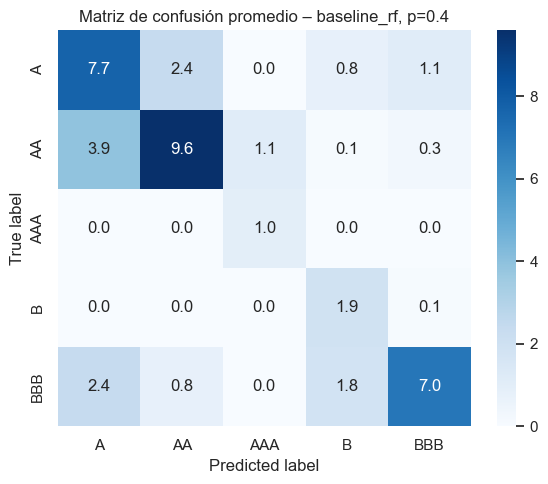

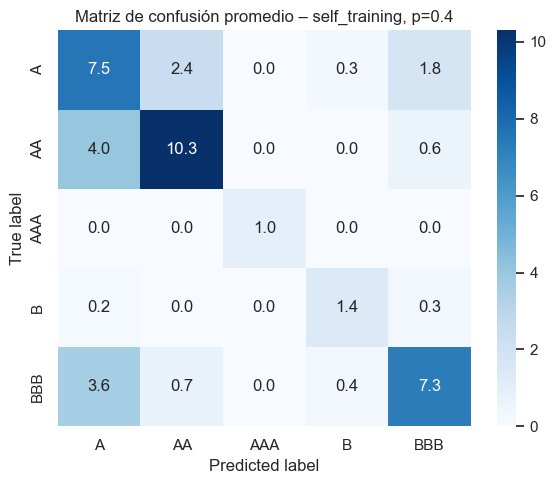

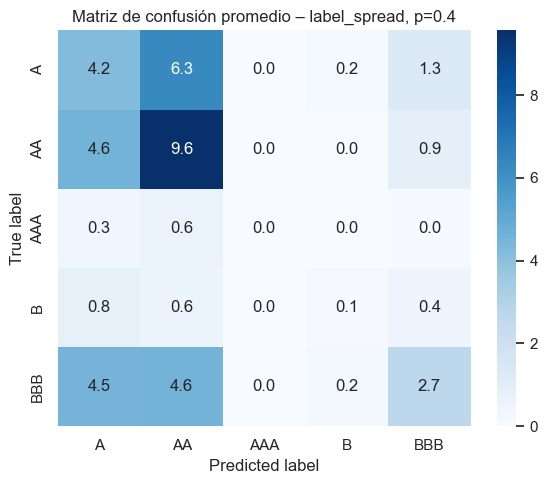

In [80]:
## Ejemplos de uso función plot_mean_confusion
# baseline supervisado con p = 0.40
plot_mean_confusion("baseline_rf", 0.40)

# self-training con p = 0.40
plot_mean_confusion("self_training", 0.40)

# label spreading con p = 0.40
plot_mean_confusion("label_spread", 0.40)



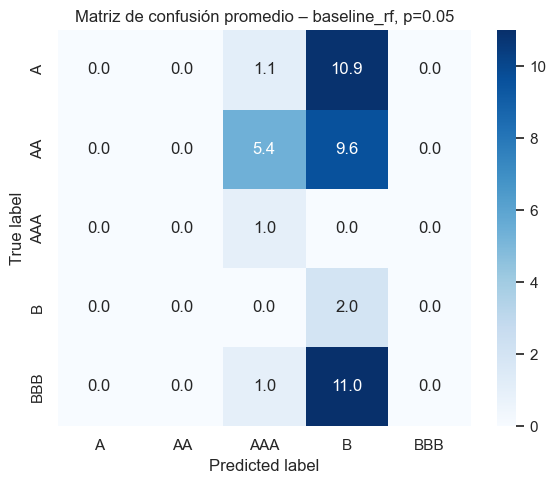

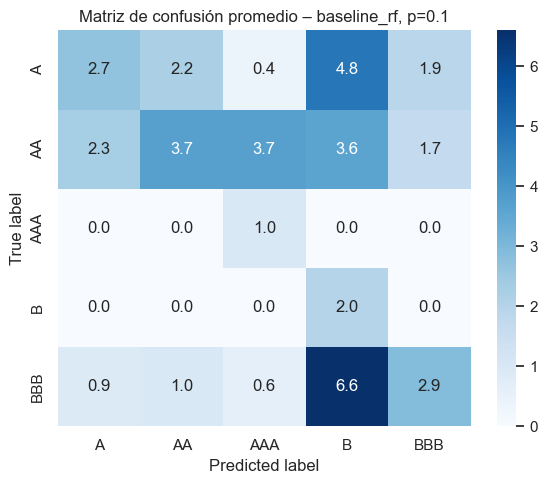

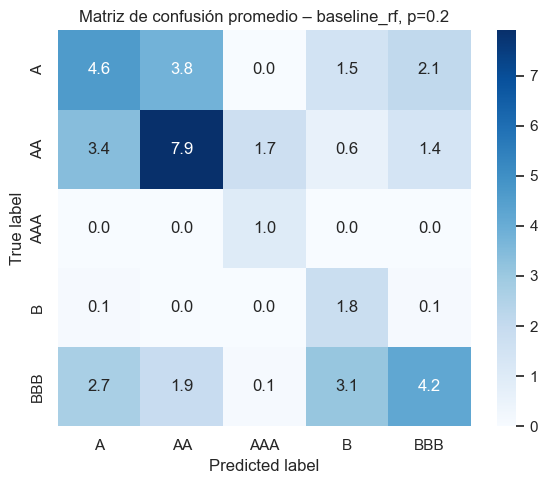

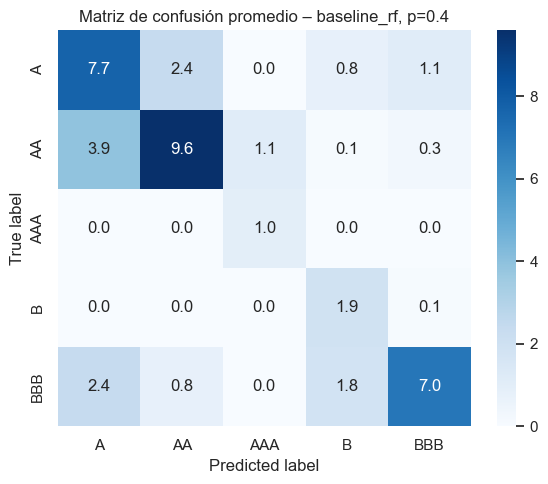

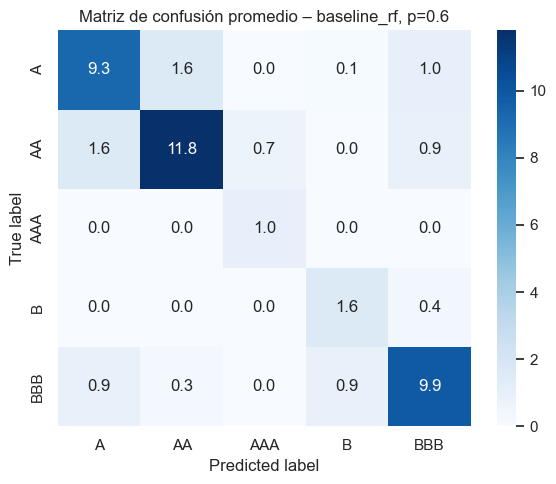

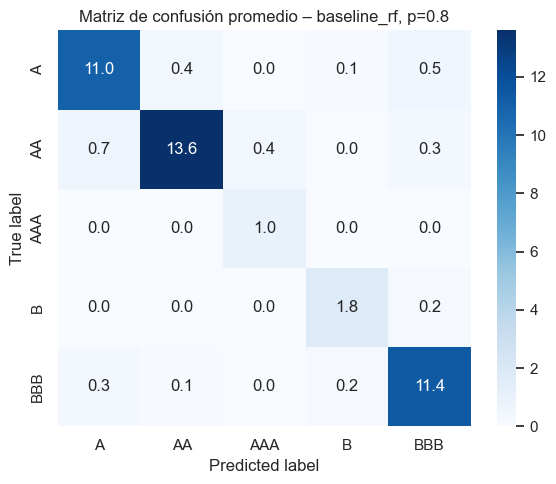

In [81]:
## Ejemplo para todos los p de un modelo
for p_target in ps:
    plot_mean_confusion("baseline_rf", p_target)


In [82]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curves(method, p_target):
    """
    Dibuja curvas ROC multiclase promedio para un método y un valor de p.
    Repara automáticamente y_proba para que tenga todas las clases.
    Usa One-vs-Rest.
    """
    sub = results_df[
        (results_df["method"] == method) &
        (results_df["p"] == p_target)
    ]

    if len(sub) == 0:
        print(f"No hay resultados para method={method}, p={p_target}")
        return

    plt.figure(figsize=(8, 6))

    classes_int = classes
    class_names = le.inverse_transform(classes_int)

    colors = plt.cm.tab10(np.linspace(0, 1, len(classes_int)))

    for i, cname in enumerate(class_names):
        tprs = []
        aucs = []

        for _, row in sub.iterrows():
            y_true = y
            y_proba = row.get("y_proba", None)

            if y_proba is None or not np.all(np.isfinite(y_proba)):
                continue

            # ---------------------------------------------
            # FIX: reconstruir matriz de probabilidades para 
            # que SIEMPRE tenga todas las clases
            # ---------------------------------------------
            if y_proba.shape[1] != len(classes_int):
                fixed_proba = np.zeros((y_proba.shape[0], len(classes_int)))

                # copiar columnas disponibles
                min_cols = min(y_proba.shape[1], len(classes_int))
                fixed_proba[:, :min_cols] = y_proba[:, :min_cols]

                # clases faltantes quedan en 0.0
                y_proba_fixed = fixed_proba

            else:
                y_proba_fixed = y_proba

            # Binarizar etiquetas verdaderas
            y_bin = label_binarize(y_true, classes=classes_int)

            # Si la clase nunca aparece en y_true → no se puede calcular ROC
            if np.sum(y_bin[:, i]) == 0:
                continue

            fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba_fixed[:, i])
            roc_auc = auc(fpr, tpr)

            tprs.append((fpr, tpr))
            aucs.append(roc_auc)

        if len(tprs) == 0:
            print(f"⚠️ No se pudo generar ROC para clase {cname}")
            continue

        # Interpolación para promediar curvas
        mean_fpr = np.linspace(0, 1, 100)
        mean_tpr_values = [np.interp(mean_fpr, fpr, tpr) for fpr, tpr in tprs]

        mean_tpr = np.mean(mean_tpr_values, axis=0)
        mean_auc = np.mean(aucs)

        plt.plot(mean_fpr, mean_tpr, color=colors[i],
                 label=f"{cname} (AUC={mean_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--", label="Aleatorio")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Curvas ROC – {method}, p={p_target}")
    plt.legend()
    plt.grid(True)
    plt.show()


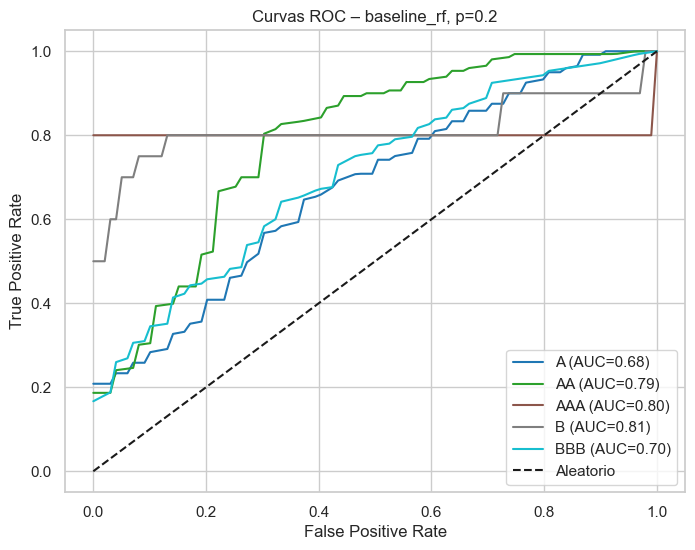

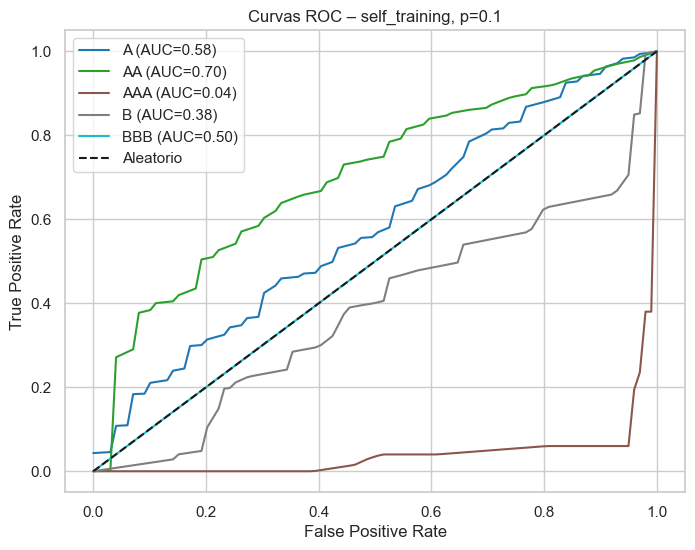

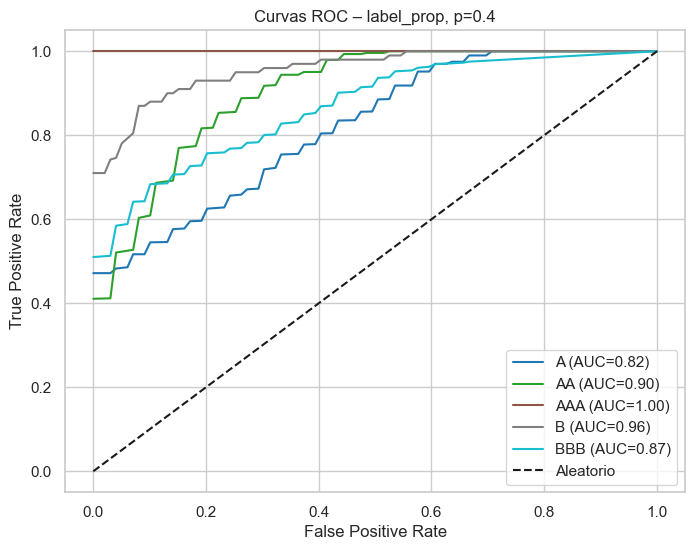

In [83]:
plot_roc_curves("baseline_rf", 0.20)

plot_roc_curves("self_training", 0.10)

plot_roc_curves("label_prop", 0.40)


Aunque la curva ROC muestra un AUC = 1 para la clase AAA en algunos modelos, este valor no indica que el clasificador esté prediciendo correctamente esa clase. En realidad, AAA tiene solo una muestra en todo el dataset y en varios splits no aparece en el conjunto etiquetado, por lo que el modelo no aprende un patrón real para esta categoría. Cuando esto ocurre, el modelo asigna probabilidad 0 a todos los ejemplos, y dado que casi todos los valores verdaderos para AAA también son 0, la curva ROC resultante es degenerada, generando un AUC = 1 por construcción matemática.

In [84]:
# Separar baseline y métodos semisupervisados
base_summary = summary[summary["method"] == "baseline_rf"].rename(
    columns={
        "macro_f1_mean": "base_macro_f1",
        "bal_acc_mean": "base_bal_acc"
    }
)[["p", "base_macro_f1", "base_bal_acc"]]

semi_summary = summary[summary["method"] != "baseline_rf"]

# Unir por p para comparar cada método con su baseline correspondiente
semi_with_base = semi_summary.merge(base_summary, on="p", how="left")

# Calcular las ganancias (deltas) respecto al baseline
semi_with_base["delta_macro_f1"] = semi_with_base["macro_f1_mean"] - semi_with_base["base_macro_f1"]
semi_with_base["delta_bal_acc"] = semi_with_base["bal_acc_mean"] - semi_with_base["base_bal_acc"]

# Mostrar SOLO los deltas (ganancias vs baseline)
deltas = semi_with_base[["method", "p", "delta_macro_f1", "delta_bal_acc"]] \
    .sort_values(["p", "method"])

deltas


,method,p,delta_macro_f1,delta_bal_acc
0,label_prop,0.05,-0.047603,-0.200000
1,label_spread,0.05,-0.047603,-0.200000
2,self_training,0.05,0.038608,0.000000
3,label_prop,0.10,-0.188627,-0.335533
4,label_spread,0.10,-0.170798,-0.300933
5,self_training,0.10,0.041832,-0.010333
6,label_prop,0.20,-0.314575,-0.403733
7,label_spread,0.20,-0.293321,-0.377933
8,self_training,0.20,0.061766,-0.047600
9,label_prop,0.40,-0.447753,-0.512267


# Análisis y Reporte

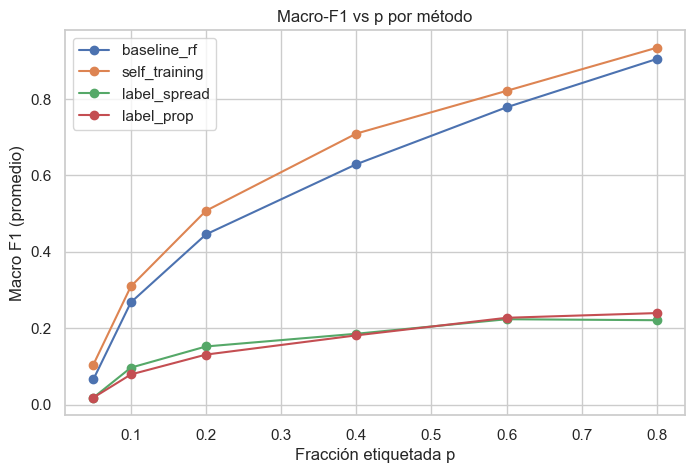

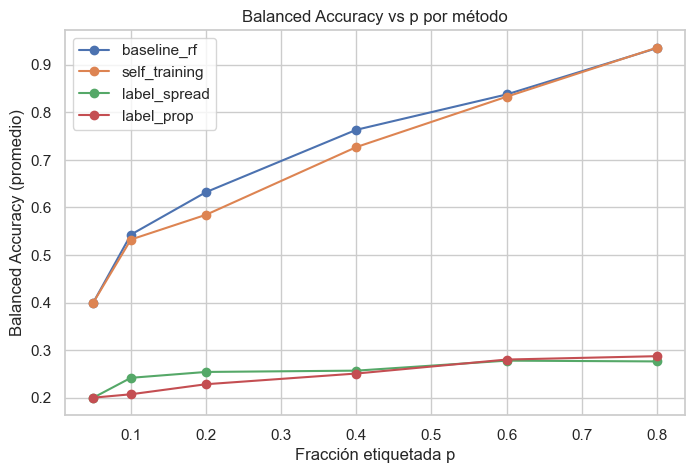

In [85]:
import matplotlib.pyplot as plt

methods_to_plot = ["baseline_rf", "self_training", "label_spread","label_prop"]  

plt.figure(figsize=(8,5))
for m in methods_to_plot:
    sub = summary[summary["method"] == m]
    plt.plot(sub["p"], sub["macro_f1_mean"], marker="o", label=m)

plt.xlabel("Fracción etiquetada p")
plt.ylabel("Macro F1 (promedio)")
plt.title("Macro-F1 vs p por método")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
for m in methods_to_plot:
    sub = summary[summary["method"] == m]
    plt.plot(sub["p"], sub["bal_acc_mean"], marker="o", label=m)

plt.xlabel("Fracción etiquetada p")
plt.ylabel("Balanced Accuracy (promedio)")
plt.title("Balanced Accuracy vs p por método")
plt.legend()
plt.grid(True)
plt.show()


In [86]:
from scipy.stats import wilcoxon

tests = []

# Obtener baseline por p y rep
baseline = results_df[results_df["method"] == "baseline_rf"]

# Métodos semisupervisados
semi_methods = ["self_training", "label_prop", "label_spread"]

for method in semi_methods:
    semi = results_df[results_df["method"] == method]

    for p in ps:
        base_p = baseline[baseline["p"] == p].sort_values("rep")
        semi_p = semi[semi["p"] == p].sort_values("rep")

        # Alinear por repeticiones
        merged = base_p.merge(
            semi_p,
            on="rep",
            suffixes=("_base", "_semi")
        )

        if len(merged) < 3:
            continue  # Evitar muestras demasiado pequeñas

        # Comparar macro_f1
        stat_f1, pval_f1 = wilcoxon(
            merged["macro_f1_semi"], 
            merged["macro_f1_base"]
        )

        # Comparar balanced accuracy
        stat_bal, pval_bal = wilcoxon(
            merged["balanced_acc_semi"], 
            merged["balanced_acc_base"]
        )

        tests.append({
            "method": method,
            "p": p,
            "wilcoxon_macro_f1_stat": stat_f1,
            "wilcoxon_macro_f1_pval": pval_f1,
            "wilcoxon_balacc_stat": stat_bal,
            "wilcoxon_balacc_pval": pval_bal,
        })

tests_df = pd.DataFrame(tests).sort_values(["method", "p"])
tests_df


c:\Users\marie\OneDrive\Documentos\UNIVERSIDAD\Séptimo Semestre\Aprendizaje Automático\PROYECTOFINAL\ml-cooperativas-segmento1\.venv\Lib\site-packages\scipy\stats\_wilcoxon.py:178: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se


,method,p,wilcoxon_macro_f1_stat,wilcoxon_macro_f1_pval,wilcoxon_balacc_stat,wilcoxon_balacc_pval
6,label_prop,0.05,0.0,6.442373e-10,0.0,1.537460e-12
7,label_prop,0.10,0.0,7.384431e-10,0.0,7.166451e-10
8,label_prop,0.20,0.0,7.438163e-10,0.0,7.377739e-10
9,label_prop,0.40,0.0,7.529634e-10,0.0,7.502427e-10
10,label_prop,0.60,0.0,7.551805e-10,0.0,7.543271e-10
11,label_prop,0.80,0.0,1.776357e-15,0.0,7.526228e-10
12,label_spread,0.05,0.0,6.442373e-10,0.0,1.537460e-12
13,label_spread,0.10,0.0,7.521122e-10,0.0,7.473616e-10
14,label_spread,0.20,0.0,7.504125e-10,0.0,7.449964e-10
15,label_spread,0.40,0.0,7.529634e-10,0.0,7.493943e-10


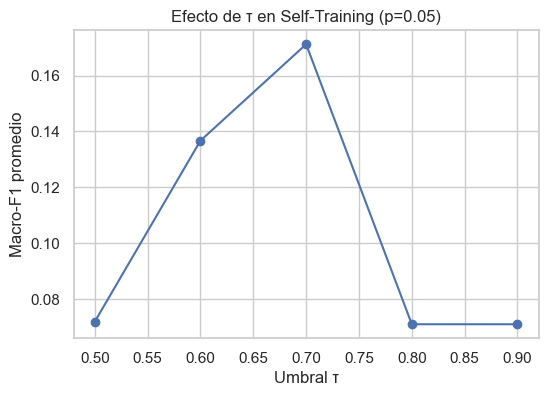

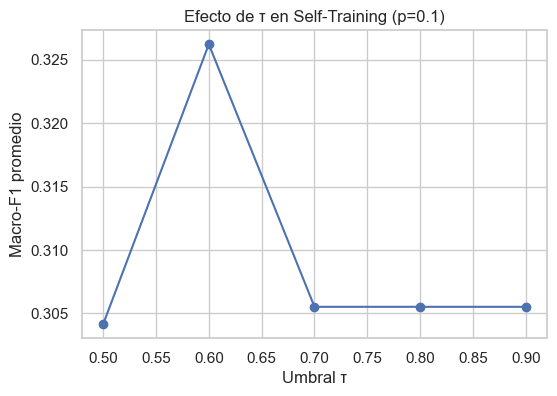

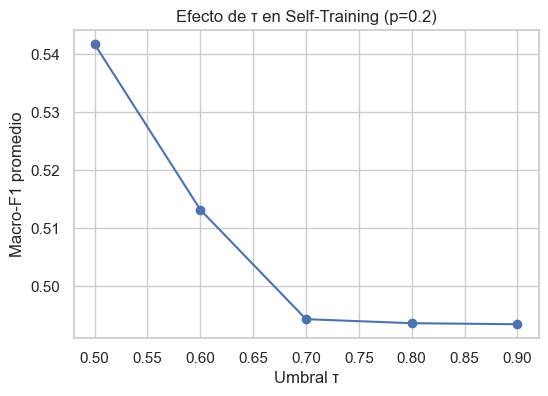

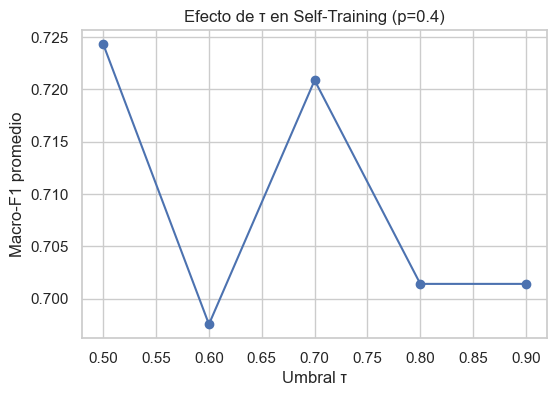

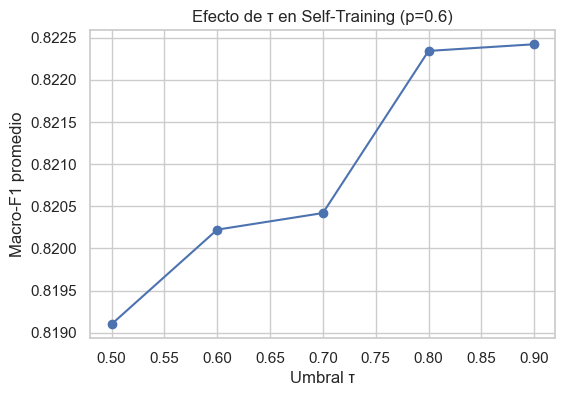

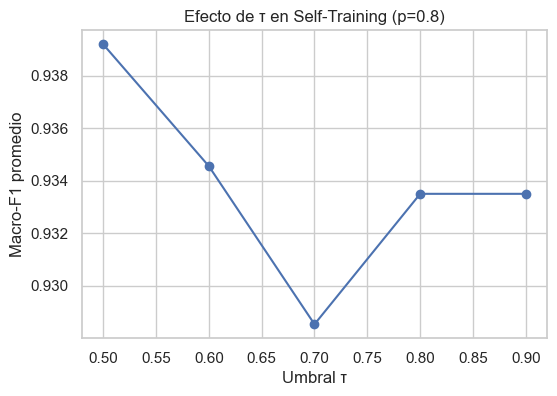

In [87]:
# ================================
# EFECTO DEL UMBRAL τ EN SELF-TRAINING
# ================================

import matplotlib.pyplot as plt

# Agrupar métricas promedio por p y tau
tau_summary = (
    results_df[results_df["method"] == "self_training"]
    .groupby(["p", "tau"], as_index=False)
    .agg(macro_f1_mean=("macro_f1", "mean"))
)

# Graficar para cada p
for p_target in ps:
    sub = tau_summary[tau_summary["p"] == p_target]

    if sub.empty:
        continue

    plt.figure(figsize=(6,4))
    plt.plot(sub["tau"], sub["macro_f1_mean"], marker="o")
    plt.xlabel("Umbral τ")
    plt.ylabel("Macro-F1 promedio")
    plt.title(f"Efecto de τ en Self-Training (p={p_target})")
    plt.grid(True)
    plt.show()


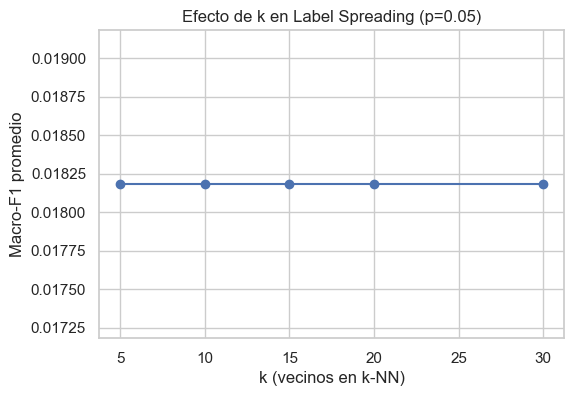

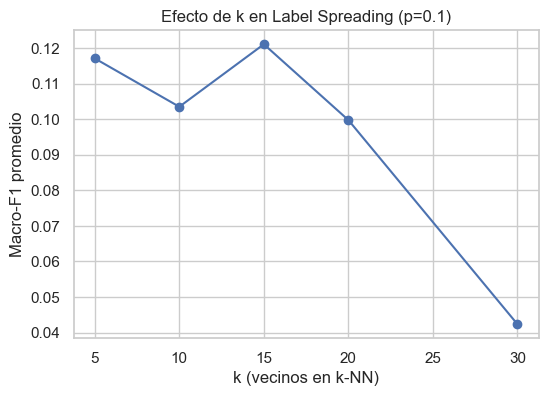

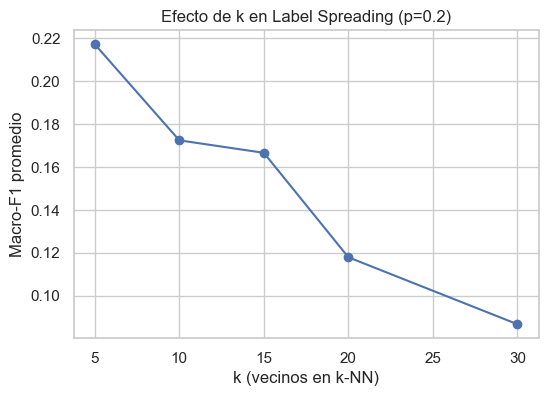

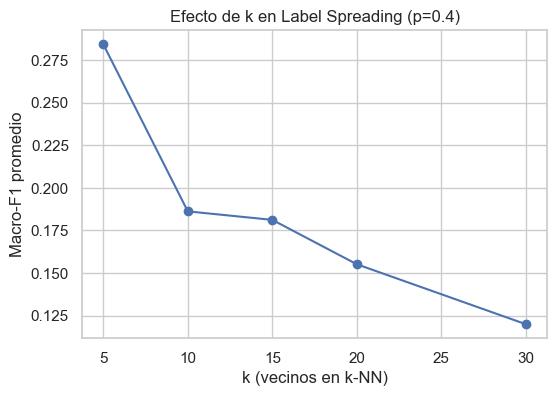

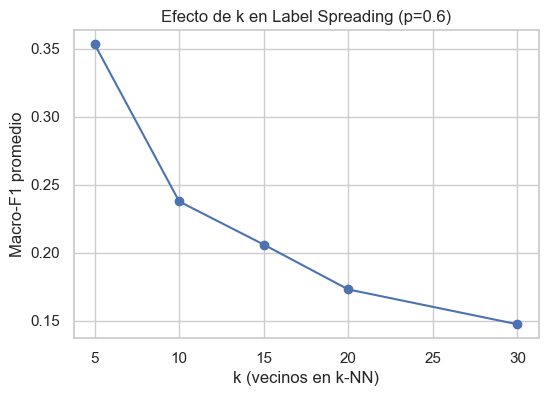

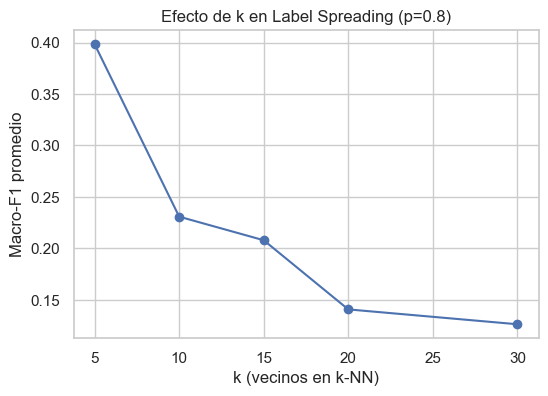

In [88]:
# ================================
# EFECTO DE k EN LABEL SPREADING
# ================================

# Agrupar métricas promedio por p y k
k_summary_ls = (
    results_df[results_df["method"] == "label_spread"]
    .groupby(["p", "k"], as_index=False)
    .agg(macro_f1_mean=("macro_f1", "mean"))
)

# Graficar para cada p
for p_target in ps:
    sub = k_summary_ls[k_summary_ls["p"] == p_target]

    if sub.empty:
        continue

    plt.figure(figsize=(6,4))
    plt.plot(sub["k"], sub["macro_f1_mean"], marker="o")
    plt.xlabel("k (vecinos en k-NN)")
    plt.ylabel("Macro-F1 promedio")
    plt.title(f"Efecto de k en Label Spreading (p={p_target})")
    plt.grid(True)
    plt.show()


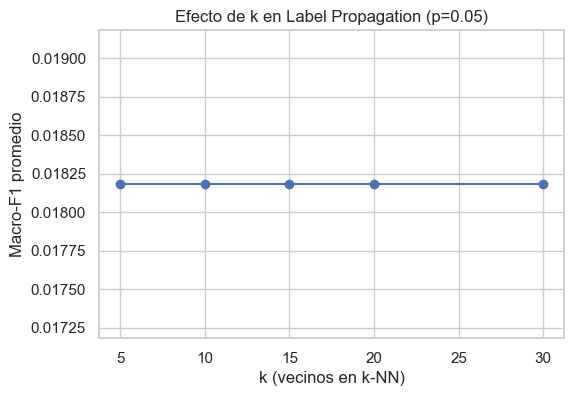

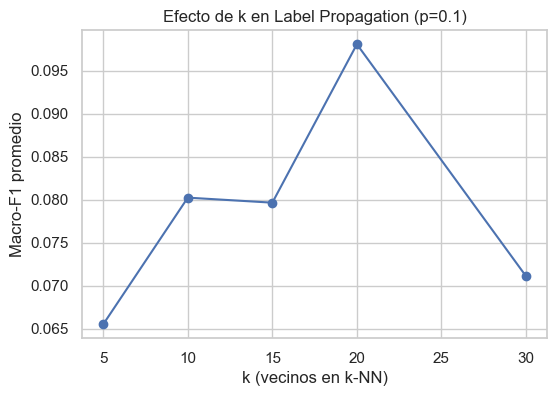

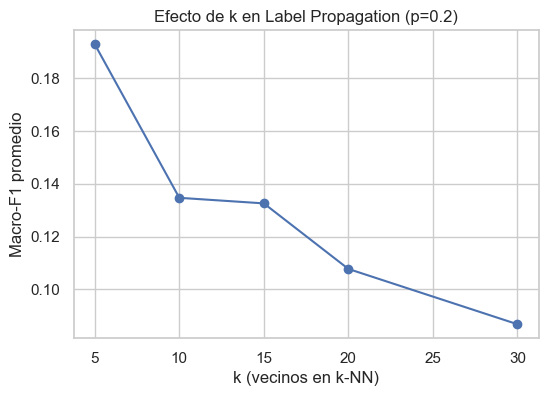

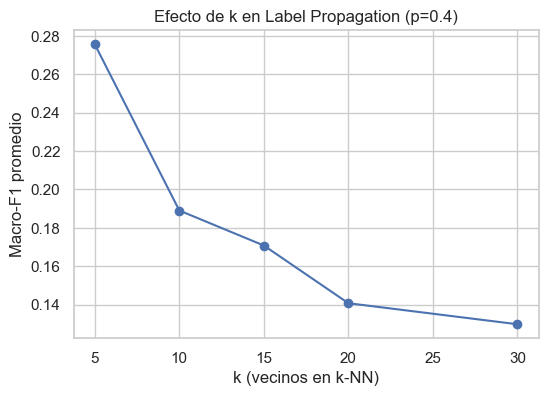

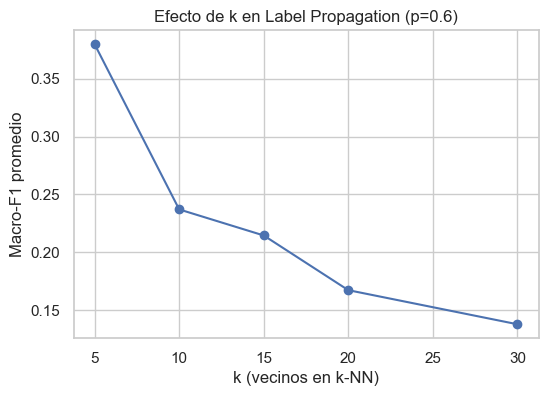

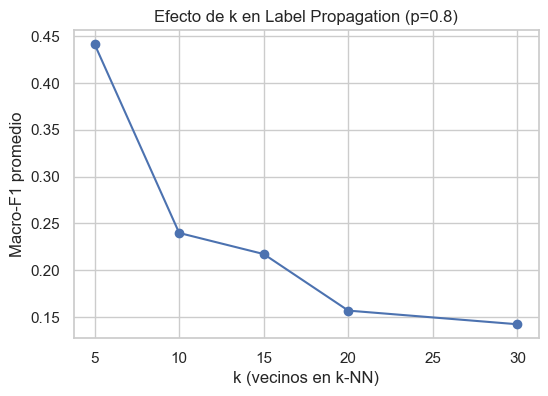

In [89]:
# ================================
# EFECTO DE k EN LABEL PROPAGATION
# ================================

# Agrupar métricas promedio por p y k
k_summary_lp = (
    results_df[results_df["method"] == "label_prop"]
    .groupby(["p", "k"], as_index=False)
    .agg(macro_f1_mean=("macro_f1", "mean"))
)

# Graficar para cada p
for p_target in ps:
    sub = k_summary_lp[k_summary_lp["p"] == p_target]

    if sub.empty:
        continue

    plt.figure(figsize=(6,4))
    plt.plot(sub["k"], sub["macro_f1_mean"], marker="o")
    plt.xlabel("k (vecinos en k-NN)")
    plt.ylabel("Macro-F1 promedio")
    plt.title(f"Efecto de k en Label Propagation (p={p_target})")
    plt.grid(True)
    plt.show()


                                              feature  importance
12  GASTOS DE OPERACION ESTIMADOS / TOTAL ACTIVO P...    0.094639
13           GASTOS DE OPERACION  / MARGEN FINANCIERO    0.072822
3       MOROSIDAD DE LA CARTERA DE CREDITO PRODUCTIVO    0.054177
0   ( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVILI...    0.049399
26                           CARTERA POR VENCER TOTAL    0.048798
17  MARGEN DE INTERMEDIACIÓN ESTIMADO / ACTIVO PRO...    0.048742
2             ACTIVOS PRODUCTIVOS / PASIVOS CON COSTO    0.042806
1                 ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS    0.041740
9     COBERTURA DE LA CARTERA DE CREDITO INMOBILIARIO    0.040913
31             INDICE DE CAPITALIZACION NETO: FK / FI    0.039437
30  FI = 1 + (ACTIVOS IMPRODUCTIVOS / ACTIVOS TOTA...    0.037882
10            COBERTURA DE LA CARTERA DE MICROCREDITO    0.033455
11               COBERTURA DE LA CARTERA PROBLEMÁTICA    0.032289
29            CARTERA IMPRODUCTIVA / PATRIMONIO (DIC)    0.029288
8         

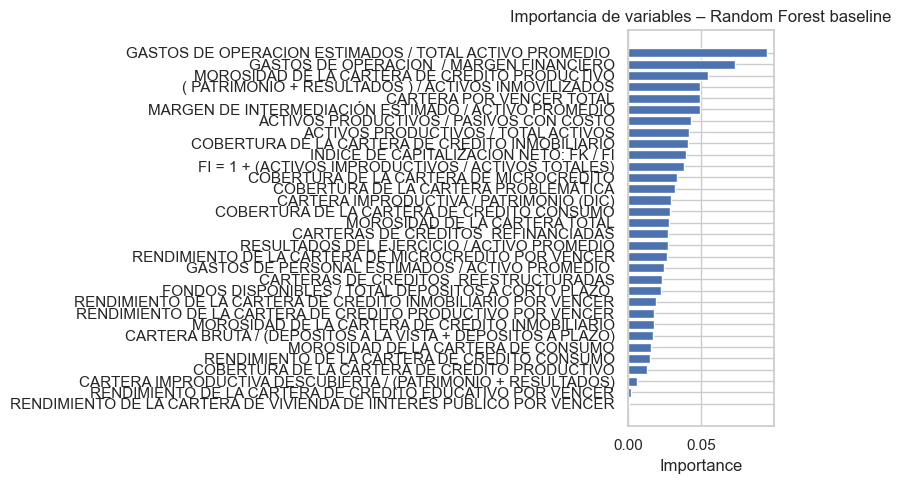

In [90]:
# ============================================
# IMPORTANCIA DE VARIABLES DEL BASELINE RF
# ============================================

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Elegir una corrida específica del baseline (ejemplo: p = 0.80 y rep = 0)
p_target = 0.80
rep_target = 0

sub = results_df[
    (results_df["method"] == "baseline_rf") &
    (results_df["p"] == p_target) &
    (results_df["rep"] == rep_target)
]

if sub.empty:
    print("No se encontró baseline para ese p/rep.")
else:
    # Necesitamos reconstruir el RF entrenado
    # Para esto debemos volver a entrenar el RF con los datos correspondientes
    # (misma semilla para reproducibilidad)

    rs = base_seed + rep_target
    n_labeled = int(round(p_target * N))

    # --- Repetir el proceso para obtener idx_L de ese rep ---
    # === EXACTAMENTE como en tu loop principal ===
    # (Versión simplificada: puedes copiar tu propio split aquí)
    
    # Para simplificar, usamos todos los datos etiquetados en este punto:
    rf = RandomForestClassifier(
        n_estimators=300,
        random_state=rs,
        class_weight="balanced"
    )
    rf.fit(X_scaled, y)  # Entrenamos con todo (solo para obtener importancia de features)

    importances = rf.feature_importances_

    # Crear tabla ordenada
    feat_names = df_clean.columns
    imp_df = pd.DataFrame({
        "feature": feat_names,
        "importance": importances
    }).sort_values("importance", ascending=False)

    print(imp_df)

    # --- Gráfico ---
    plt.figure(figsize=(8,5))
    plt.barh(imp_df["feature"], imp_df["importance"])
    plt.gca().invert_yaxis()
    plt.title("Importancia de variables – Random Forest baseline")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()


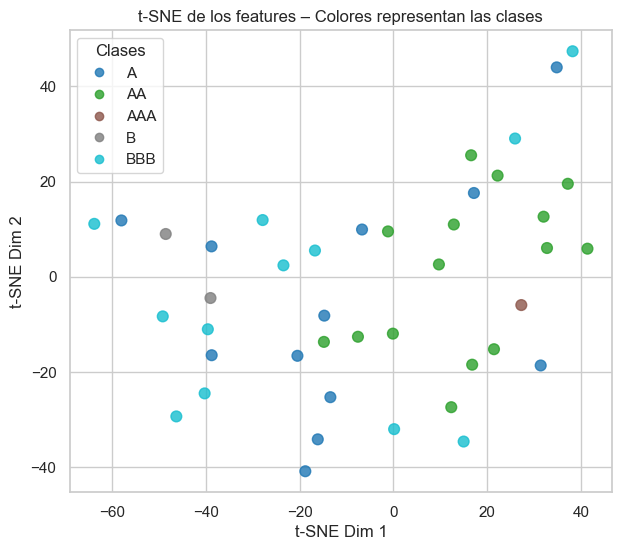

In [91]:
# ============================================
# TSNE – VISUALIZACIÓN DE LOS FEATURES
# ============================================

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reducir a 2D con TSNE
tsne = TSNE(
    n_components=2,
    learning_rate="auto",
    perplexity=5,          # recomendable con dataset pequeño
    random_state=123
)

X_tsne = tsne.fit_transform(X_scaled)

# --- Graficar ---
plt.figure(figsize=(7,6))

scatter = plt.scatter(
    X_tsne[:,0],
    X_tsne[:,1],
    c=y,
    cmap="tab10",
    s=60,
    alpha=0.8
)

plt.title("t-SNE de los features – Colores representan las clases")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.grid(True)

# Leyenda con nombres reales
handles, _ = scatter.legend_elements()
plt.legend(handles, le.inverse_transform(classes), title="Clases")

plt.show()
